In [1]:
#//*** GEOPANDAS sources
#https://jcutrer.com/python/learn-geopandas-plotting-usmaps
#https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
#https://geopandas.org/docs/user_guide/mapping.html

#//*** Build Custom Color Gradients
#https://coolors.co/gradient-palette/ffffff-e0472b?number=9

#//*** pandas_bokeh
#//*** https://pythonawesome.com/bokeh-plotting-backend-for-pandas-and-geopandas/

#//*** Clean geopandas install
#//***conda create -n geopandas -c conda-forge python=3.8 geopandas

Hospitalization research:
Data.gov search for tag: hhs-covid-19

posible lead: https://healthdata.gov/dataset/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/4cnb-m4rz

possible lead individual facility breakdown by week May - October 2021: https://healthdata.gov/dataset/COVID-19-Hospital-Data-Coverage-Report-v4wn-auj8-A/ewep-8fwa

This look like State Level Data: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh

Data CSV Link: https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD

Healthdata.gov Hospitalization Search: https://healthdata.gov/browse?q=hospitalization&sortBy=relevance

Hospital Facility TimeSeries: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u


Other Sources:
 - COVID-19 State and County Policy Orders (infographic?): https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders-9408a

- [Graph: Infographic Visualization](#infographic_visualization)

<a id="top"></a> 
## Internal Links ##

- Working [working](#working).

- [Load/Rebuild County Level Combined Data Set: Vaccination, Cases, Deaths: rebuild county_daily_df](#rebuild_county_daily_df)

- [Load/Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths: rebuild state_daily_df](#rebuild_state_daily_df)

- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)

- [ Load or Rebuild County Level Vaccine Data Set: county_vax_df](#rebuild_county_vax_df)

- [ Build Vaccine Tiers: County Data: county_tier_df](#build_tiers_county)

- [Build Vaccine Tiers: Statewide Data](#build_tiers_statewide)

- [ Build: hospital_df ](#build_hospital_df)

- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

## Analyze ##
- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)

## Graphs ##
- [ Blog Graphs ](#build_blog_graphs)

## HTML Processing ##


### CDC Community Transmission Guidelines

https://covid.cdc.gov/covid-data-tracker/#county-view



![](transmission_risk.png)

<a id="working"></a> 
# Working #

In [2]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time 
import random
from PIL import Image

import shutil
import json

import geopandas as gpd

import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot

import pandas_bokeh
pandas_bokeh.output_notebook()

#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
#https://docs.bokeh.org/en/latest/docs/user_guide/embed.html

#//*** Bokeh Categorical Labels
#https://docs.bokeh.org/en/0.12.10/docs/user_guide/categorical.html

#//*** Color Palettes: https://docs.bokeh.org/en/latest/docs/reference/palettes.html
#//*** Hover Tools: https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
from datetime import datetime
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 200)

#//*** Holds 
out_plot = {}
out_stats = {}
out_images = []
out_exec_summary_images = []

med_figsize_x =634
med_figsize_y = 512

#df_list = []

#from sklearn import linear_model
#from math import sqrt
#from sklearn.metrics import mean_squared_error



Loading BokehJS ...

In [3]:
#"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"

#Hospitalizations - State
#https://www.cdc.gov/nhsn/covid19/report-patient-impact.html#anchor_1594393649
#DL: https://www.cdc.gov/nhsn/pdfs/covid19/covid19-NatEst.csv

# File Control #
 * use_cached_files = True - Use the Locally cached versions of the data
 * use_cached_files = False - Download updated source Data
 
 * rebuild_master_files = True - Rebuild county_daily_df. Takes 5-10 minutes
 * rebuild_master_files = False - Uses the cached version of the files

In [4]:
#//************************************************************************
#//*** If True, will rely on locally stored files
#//*** If False, will Download current data and rebuild all data sets
#//*** Should only be set to False if Data needs to be updated
#//************************************************************************
#use_cached_files = True
#rebuild_master_files = False

out_controls = {}
manage_df = {}

# Filepaths #

In [5]:
#//*** Raw Filenames
confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename = "z_us_death_cases.csv"
vaccine_data_filename = "z_us_vaccination.csv"
county_vaccine_data_filename = "z_us_county_vaccination.csv.zip"
state_hospital_filename = "z_state_hospital.csv"

#//*** Filenames for Caching files locally
attrib_confirm_filename = "attrib_confirm_df.dat.zip"
attrib_death_filename =  "attrib_death_df.dat.zip"
all_dates_filename = "all_dates.json"
geo_vax_filename = "geo_vax_df.dat"
casevax_filename = "casevax.dat.zip"
county_daily_df_filename = "z_county_daily_df.csv.zip"
state_daily_df_filename = "z_state_daily_df.csv.zip"
hospital_df_filename = "z_hospital_df.csv.zip"

county_tier_df_filename = "z_county_tier_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"

In [6]:
county_daily_df = pd.read_pickle(county_daily_df_filename)


<a id="rebuild_county_daily_df"></a> 
# Load or Rebuild County Level Combined Data Set: Cases & Deaths #

<a id="rebuild_county_vax_df"></a> 
# Load or Rebuild County Level Vaccine Data Set: county_vax_df #

In [7]:
#print("Loading Raw Vaccine Data")
#//*** read Raw Vaccine csv
county_vax_df = pd.read_pickle(county_vaccine_data_filename)

manage_df["county_vax_df"] = "County Vaccination Data [ 2020-12-13 - Present ]"

#//*** Filter Columns to get just the Completed Values
cols = ['Date','FIPS','Recip_County','Recip_State','Series_Complete_Pop_Pct','Series_Complete_Yes','Administered_Dose1_Pop_Pct','Administered_Dose1_Recip']


#//*** remove States not in continental US
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AK" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "HI" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AS" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "GU" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "MP" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "PR" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "VI" ]
county_vax_df = county_vax_df[county_vax_df["FIPS"] != "UNK" ]
county_vax_df['FIPS'] = county_vax_df['FIPS'].astype(int)
county_vax_df['Date'] = county_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date())

county_vax_df = county_vax_df[cols]

#//*** Cleanup Column Names
ren_cols = {
'Administered_Dose1_Recip' : 'first_dose_count',
'Administered_Dose1_Pop_Pct' : 'first_dose_pct',
'Series_Complete_Yes' : 'total_vaccinated_count',
'Series_Complete_Pop_Pct' : 'total_vaccinated_percent',
}

cols = list(county_vax_df.columns)

for find,replace in ren_cols.items():
    cols = [replace if i==find else i for i in cols]

county_vax_df.columns=cols
    
county_vax_df

Date   FIPS       Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count
0        2021-11-08   5001    Arkansas County          AR                      51.0                    8915            58.5           10232.0
1        2021-11-08  26115      Monroe County          MI                      51.6                   77733            55.6           83649.0
2        2021-11-08   4021       Pinal County          AZ                      47.0                  217413            53.5          247540.0
3        2021-11-08  28011     Bolivar County          MS                      53.0                   16224            59.9           18336.0
5        2021-11-08  40077     Latimer County          OK                      31.1                    3135            34.5            3475.0
...             ...    ...                ...         ...                       ...                     ...             ...               ...
1086358  2020-12-13  42075     Lebanon County          PA                       0.0                       0             0.0               0.0
1086359  2020-12-13  47095        Lake County          TN                       0.0                       0             0.0               0.0
1086361  2020-12-13  33003     Carroll County          NH                       0.0                       0             0.0               0.0
1086362  2020-12-13  54075  Pocahontas County          WV                       0.0                       0             0.0               0.0
1086363  2020-12-13  23015     Lincoln County          ME                       0.0                       0             0.0               0.0

[1028955 rows x 8 columns]

<a id="rebuild_state_daily_df"></a> 
# Load or Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths #

In [8]:
state_daily_df = pd.read_pickle(state_daily_df_filename)
state_daily_df

manage_df['state_daily_df'] = "State Population Vaccination Case Death [2020-12-14 - Present]"

# Read all dates JSON
with open(all_dates_filename, "r") as infile:
    all_dates = json.loads(infile.read())['all_dates']

- [ go to Top](#top)
- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)
<a id="build_state_case_death_df"></a> 
# Build State Level: state_case_death_df - cases & deaths only #




In [9]:
#//**************************************************************************************************
#//**** Build Just Cases and Deaths at State Level. These will integrate with Hospitalizations
#//**** Orginally geo_vax_df...Now: state_daily_df
#//**************************************************************************************************

manage_df['confirm_df'] = "Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]"
manage_df['death_df'] = "Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]"
#//**** Load Confirmed Data
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df.dropna(subset=["FIPS"])

#//**** Load death Data
death_df = pd.read_csv(death_data_filename)
death_df = death_df[death_df["Admin2"] != "Unassigned"]
death_df = death_df.dropna(subset=["FIPS"])

#//**** Load raw Vax Data
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)


#//***************************************
#//*** Build Vaccine Geographic Data
#//***************************************

#//*** Get Shape File
state_case_death_df = gpd.read_file('maps\cb_2018_us_state_20m.shp')

#//*** Keep the important Columns
state_case_death_df = state_case_death_df[['STATEFP','GEOID','NAME','geometry']]

state_case_death_df['GEOID'] = state_case_death_df['GEOID'].astype(int)
state_case_death_df['STATEFP'] = state_case_death_df['STATEFP'].astype(int)



#//*** Vaccine Info only has State Abbreviations. Need to add FIPS codes to merge with geographic data
#//*** Load DF with States and FIPS values
#state_fips = pd.read_csv("state_fips.csv")
#geo_vax_df = state_fips.merge(vax_df,left_on="Postal Code",right_on="Location")

#//*** remove States not in continental US
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Alaska" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Hawaii" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Puerto Rico" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "District of Columbia" ]

#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "HI" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "AS" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "GU" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "MP" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "PR" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "VI" ]



#geo_vax_df['Date'] = geo_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

state_case_death_df = state_case_death_df.sort_values('NAME').reset_index()

#//*** Extract Deaths and Confirmed Cases From JOhns Hopkins Column wise data and merge with Vaccine Row Data

#//***Process Deaths
us_deaths_df = pd.DataFrame()

for group in death_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[12:]]
    #print(loop_stats_df.columns)

    base_row = pd.Series([group[0],group[1]['Population'].sum()], index=['state','population'])

    base_row = pd.DataFrame(base_row).transpose()
    stats_df = pd.DataFrame([[group[0]],loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['state','Date','tot_death']
    stats_df['state'] = stats_df['state'].fillna(group[0])
    base_row = base_row.merge(stats_df,left_on="state",right_on="state")
    us_deaths_df = pd.concat([us_deaths_df,base_row])

#print(us_deaths_df)

us_df = pd.DataFrame()
#//***Process confirmed and merge with deaths
for group in confirm_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[11:]]
    #print(loop_stats_df.columns)
    stats_df = pd.DataFrame([loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['Date','tot_confirm']

    us_df = pd.concat([us_df,us_deaths_df[us_deaths_df['state']==group[0]].merge(stats_df,left_on='Date',right_on='Date')])


us_df['Date'] = us_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))  
us_df = us_df.reset_index(drop='True')

for col in ['New_Cases','New_Deaths']:
    us_df[col] = np.nan



#//*** Drops Diamon Princess, Virgin Islands, and anything not listed as a state in the continental united states
state_case_death_df = state_case_death_df.merge(us_df, left_on='NAME', right_on='state')
tdf = pd.DataFrame()

for group in state_case_death_df.groupby('state'):
    loop_df = group[1].copy()
    
    
    
    loop_df['New_Cases'] = loop_df['tot_confirm'].copy().diff(2)

    #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Cases'] < 0,f'New_Cases']=0

    loop_df['case_7_day_avg'] = loop_df['New_Cases'].rolling(7).mean()
    loop_df['case_avg_100k'] = loop_df['New_Cases'] / (loop_df['population'] / 100000)
    loop_df['New_Deaths'] = loop_df['tot_death'].copy().diff(2)

            #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Deaths'] < 0,f'New_Deaths']=0
    loop_df['death_7_day_avg'] = loop_df['New_Deaths'].rolling(7).mean()
    loop_df['death_avg_100k'] = loop_df['New_Deaths'] / (loop_df['population'] / 100000)
    
    loop_df = loop_df.dropna()
    
    loop_df['loc'] = (state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0]
    
    #print((state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0])
    #print(loop_df)
    tdf = pd.concat([tdf,loop_df])
state_case_death_df = tdf
del tdf
del us_df
del us_deaths_df

state_case_death_df = state_case_death_df.sort_values(['Date','NAME'])
state_case_death_df

manage_df['state_case_death'] = "State Level Cases and Deaths Only [2020/01/30 - Present]"
#print(state_case_death_df)

<a id="rebuild_column_data_for_bokeh"></a> 
# Load or Rebuild Columwise Dataframes for Bokeh Slider Plots: attrib_confirm_df, attrib_death_df #

In [10]:
attrib_confirm_df = pd.read_pickle(attrib_confirm_filename)
manage_df['attrib_confirm_df'] = "Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]"
attrib_death_df = pd.read_pickle(attrib_death_filename)
manage_df['attrib_death_df'] = "Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]"
#print("Loading Cached: death_df")

- [ go to Top](#top)
- [ Build: hospital_df](#build_hospital_df)
<a id="build_hospital_df"></a> 
# Build: hospital_df #


In [11]:
#//*** Raw data description
#https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh
#//*** There are 116 Columns. Gotta Pair it down
manage_df['hospital_df'] = "Statewide Hospitalization Numbers [2020-01-01 - Present]"
hospital_df = pd.read_csv(state_hospital_filename)
hospital_df

#//*** Remove columns that include these words
exclude_cols = ['coverage','numerator','denominator','previous','influenza','geocoded_state','total_pediatric_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_not_reported','anticipated','staffed_icu_adult_patients_confirmed_covid','total_adult_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_no','deaths_covid']

cols = []

for col in hospital_df.columns:
    for frag in exclude_cols:
        if frag in col:
            del hospital_df[col]
            break
            
            
#//*** rename columns for redability            
ren_cols = {
    'critical_staffing_shortage_today_yes' : "short_staffed",
    'hospital_onset_covid' : 'got_covid_at_hosp',
    'inpatient_beds' : 'total_beds',
    'inpatient_beds_used' : "beds_used",
    'inpatient_beds_used_covid' : 'covid_beds_used',
    'staffed_adult_icu_bed_occupancy' : "icu_occupancy",
    'staffed_icu_adult_patients_confirmed_and_suspected_covid' : 'covid_icu',
    'total_adult_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_adult',
    'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_kids',
    'total_staffed_adult_icu_beds' : 'icu_total',
    'inpatient_beds_utilization' : 'beds_used_pct',
    'percent_of_inpatients_with_covid' : 'covid_patients_pct',
    'inpatient_bed_covid_utilization' : 'covid_beds_pct',
    'adult_icu_bed_covid_utilization' : 'icu_used',
    'adult_icu_bed_utilization' : 'icu_used_pct',
    'on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses' : 'therapy_a',
    'on_hand_supply_therapeutic_b_bamlanivimab_courses' : 'therapy_b',
    'on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses' : 'therapy_b',
    'date' : 'Date',
}

#//*** Rename Columns for readability
cols = hospital_df.columns
for find_col,replace_col in ren_cols.items():
    if find_col in cols:
        cols = np.where(cols == find_col,replace_col,cols)

hospital_df.columns = cols

#//*** Convert everything to floats where possible
for col in hospital_df.columns:
    try:
        hospital_df[col] = hospital_df[col].astype(float)
    except:
        continue
        
hospital_df['Date'] = hospital_df['Date'].apply(lambda x: datetime.strptime(x, "%Y/%m/%d").date())
        
hospital_df = hospital_df.sort_values('Date')

hospital_df

state        Date  short_staffed  got_covid_at_hosp  total_beds  beds_used  covid_beds_used  icu_occupancy  covid_icu  covid_beds_adult  covid_beds_kids  icu_total  beds_used_pct  \
29991    LA  2020-01-01            0.0                NaN         NaN        NaN              NaN            NaN        NaN               NaN              NaN        NaN            NaN   
30304    NC  2020-01-01            0.0                0.0        72.0        NaN              0.0            NaN        NaN               NaN              NaN        NaN            NaN   
25329    HI  2020-01-01            0.0                0.0         0.0        0.0              0.0            NaN        NaN               NaN              NaN        NaN            NaN   
26616    AL  2020-01-01            0.0                NaN         6.0        NaN              NaN            NaN        NaN               NaN              NaN        NaN            NaN   
32632    MT  2020-01-01            0.0                0.0        36.0       12.0              0.0            NaN        NaN               NaN              NaN        NaN       0.333333   
...     ...         ...            ...                ...         ...        ...              ...            ...        ...               ...              ...        ...            ...   
23960    NV  2021-11-08            2.0               29.0      8416.0     6616.0            711.0          684.0      156.0             710.0              1.0      819.0       0.786122   
24232    VT  2021-11-08            9.0                0.0      1236.0      864.0             45.0           82.0       16.0              45.0              0.0      101.0       0.699029   
16211    CA  2021-11-08          107.0               58.0     61683.0    47751.0           4053.0         5254.0      962.0            3992.0             61.0     6991.0       0.774135   
23723    OH  2021-11-08           28.0               24.0     28169.0    20910.0           2328.0         2921.0      606.0            2149.0            179.0     3882.0       0.742305   
22001    IA  2021-11-08            6.0                2.0      7372.0     4868.0            527.0          478.0      116.0             516.0             11.0      641.0       0.660336   

       covid_patients_pct  covid_beds_pct  icu_used  icu_used_pct  therapy_a  therapy_b  therapy_b  
29991                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
30304                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
25329                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
26616                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
32632            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
...                   ...             ...       ...           ...        ...        ...        ...  
23960            0.109217        0.085807  0.196970      0.835165     1154.0      557.0      557.0  
24232            0.053635        0.037344  0.168421      0.811881        NaN        NaN        NaN  
16211            0.085860        0.066550  0.141138      0.751538    12138.0     8223.0     3203.0  
23723            0.112312        0.083558  0.158847      0.752447      898.0      941.0      787.0  
22001            0.109815        0.072440  0.186495      0.745710       45.0        0.0       29.0  

[33059 rows x 20 columns]

<a id="build_tiers_statewide"></a> 
# Build Vaccine Tiers: Statewide Data #

In [12]:
#//*** Build State Tiers By Vaccinated Percent

plot_df = state_daily_df

print()
plot_df = plot_df[plot_df['Date'] > plot_df['Date'].unique()[0]]
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].min())
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].max())


#//*** Build Sorted list of States by Vaccination
#cats = list(plot_df[plot_df['Date'] == plot_df['Date'].min()].sort_values('death_7_day_avg',ascending=False)['state'])
#cats

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
#category_col = 'Name'
vax_range_dict = {}
vax_range_dict['40'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] < 45) ]['Name'])
vax_range_dict['45'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 45) & (plot_df['total_vaccinated_percent'] < 50)]['Name'])
vax_range_dict['50'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 50) & (plot_df['total_vaccinated_percent'] < 55)]['Name'])
vax_range_dict['55'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 55) & (plot_df['total_vaccinated_percent'] < 60)]['Name'])
vax_range_dict['60'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 60) & (plot_df['total_vaccinated_percent'] < 65)]['Name'])
vax_range_dict['65'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 65) ]['Name'])


vax_tier_state_df = pd.DataFrame()

cols = ['Date','tier','population','total_vaccinated_count','first_dose_count','tot_confirm','tot_death','New_Cases','New_Deaths']





for index in ['40','45','50','55','60','65']:

    tier_df = pd.DataFrame()

    #//*** Get DF that contains list of States. Loop through those tiers and combine them
    for group in plot_df[plot_df['Name'].str.contains('|'.join(vax_range_dict[index]))].groupby('Date'):

        loop_list = [group[0],f'total_{index}']
        for col in cols[2:]:
            loop_list.append(group[1][col].astype(int).sum())

        loop_df = pd.DataFrame(loop_list).transpose()
        loop_df.columns = cols

        for col in cols[2:]:
            loop_df[col] = loop_df[col].astype(int)
            
        tier_df = pd.concat([tier_df, loop_df])
        #print(loop_df)

    tier_df['case_7_day_avg'] = tier_df['New_Cases'].rolling(14).mean()
    tier_df['death_7_day_avg'] = tier_df['New_Deaths'].rolling(14).mean()

    tier_df['case_avg_100k'] = tier_df['case_7_day_avg'] / (tier_df['population'] / 100000) 
    tier_df['death_avg_100k'] = tier_df['death_7_day_avg'] / (tier_df['population'] / 100000) 
    
    tier_df['total_vaccinated_percent'] = tier_df['total_vaccinated_count'] / tier_df['population']
    tier_df['first_dose_pct'] = tier_df['first_dose_count'] / tier_df['population']
    
    vax_tier_state_df = pd.concat([vax_tier_state_df,tier_df])

vax_tier_state_df.dropna(inplace=True)
vax_tier_state_df = vax_tier_state_df.reset_index()
#print(vax_tier_state_df)

#//*** Build Sorted list of States by Vaccination
cats = list(vax_tier_state_df['tier'].unique())
cats
manage_df['vax_tier_state_df'] = "State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]"
vax_tier_state_df[vax_tier_state_df['tier'] == 'total_40'].reset_index()


41.1
71.7


level_0  index       Date      tier  population  total_vaccinated_count  first_dose_count  tot_confirm  tot_death  New_Cases  New_Deaths  case_7_day_avg  death_7_day_avg  case_avg_100k  \
0          0      0 2020-12-28  total_40     4157971                       0                 0       262150       3045       3040          65     5152.357143        76.357143     123.915177   
1          1      0 2020-12-29  total_40     4157971                       0                 0       265220       3082       5095         101     5085.214286        77.142857     122.300379   
2          2      0 2020-12-30  total_40     4157971                       0                 0       268222       3126       6072          81     5074.285714        75.428571     122.037545   
3          3      0 2020-12-31  total_40     4157971                       0                 0       270820       3212       5600         130     5033.928571        75.642857     121.066948   
4          4      0 2021-01-01  total_40     4157971                       0                 0       273306       3235       5084         109     4917.285714        74.928571     118.261665   
..       ...    ...        ...       ...         ...                     ...               ...          ...        ...        ...         ...             ...              ...            ...   
310      310      0 2021-11-03  total_40     4157971                 1778344           2055788       673396       9333       4427         138     4318.928571        92.428571     103.871060   
311      311      0 2021-11-04  total_40     4157971                 1779754           2057874       675483       9383       4657         124     4217.000000        89.357143     101.419659   
312      312      0 2021-11-05  total_40     4157971                 1781534           2060244       677535       9405       4139          72     4078.428571        86.357143      98.086989   
313      313      0 2021-11-06  total_40     4157971                 1783136           2062508       678750       9407       3267          24     3983.642857        83.714286      95.807375   
314      314      0 2021-11-07  total_40     4157971                 1784748           2064612       679788       9407       2253           2     3967.285714        83.142857      95.413982   

     death_avg_100k  total_vaccinated_percent  first_dose_pct  
0          1.836404                  0.000000        0.000000  
1          1.855301                  0.000000        0.000000  
2          1.814072                  0.000000        0.000000  
3          1.819225                  0.000000        0.000000  
4          1.802047                  0.000000        0.000000  
..              ...                       ...             ...  
310        2.222925                  0.427695        0.494421  
311        2.149056                  0.428034        0.494923  
312        2.076906                  0.428462        0.495493  
313        2.013345                  0.428848        0.496037  
314        1.999602                  0.429235        0.496543  

[315 rows x 17 columns]

- [ go to Top](#top)
- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

<a id="state_hosp_tiers_df"></a> 
# Build: state_hosp_tiers_df #

In [13]:
working_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()]



hosp_tier_dict = {}
#//*** Group FIPS by Total vaccinated Percent
#//*** Put Results in Dictionary
for i in range(20):
    low_i = i * 5
    high_i = low_i+5
    loop_df = working_df[ (working_df['total_vaccinated_percent'] >= low_i) & (working_df['total_vaccinated_percent'] < high_i) ]
    if len(loop_df) > 0:
        
        hosp_tier_dict[low_i] = {'FIPS' : list(loop_df['FIPS'].astype(int).unique()), 'state' : list(loop_df['Postal Code'].unique())}
print(hosp_tier_dict)


state_hosp_tiers_df = pd.DataFrame()

hosp_cols = ['total_beds','beds_used','covid_beds_used','icu_total','icu_used','covid_icu','covid_beds_adult','covid_beds_kids']

sum_cols_state = ['population','tot_confirm','tot_death']

working_df = state_case_death_df

#//*** Get DF that contains list of States. Loop through those tiers and combine them
for tier,loop_dict in hosp_tier_dict.items():
    FIPS_list = loop_dict['FIPS']
    state_list = loop_dict['state']
    date_df = pd.DataFrame()
    print(tier)
    for group in working_df[working_df['GEOID'].isin(FIPS_list)].groupby('Date'):
        
        #print(hospital_df[hospital_df['Date'] == group[0]])
        
        #//*** Get the first row, this will hold all the columns and attributes
        out_df = group[1].iloc[0].copy()
        
        
        #//*** Sum appropriate columns for aggregation
        for col in sum_cols_state:
            
            val = group[1][col].sum()
                
            out_df[col] = val

        #//*** Keep a list of all FIPS values in tier, just in case
        out_df['FIPS'] = FIPS_list

        out_df['tier'] = f"total_{tier}"
        
        
        #//*** Get Hospital values for given states on given day
        thosp = hospital_df[hospital_df['state'].isin(state_list)]
        thosp = thosp[thosp['Date']==group[0]]
        
        #print(thosp)
        #print(thosp['total_beds'].sum())
        #//*** Sum the hospital columns
        for col in hosp_cols:
            out_df[col] = np.array(thosp[col].sum())
            #print(col," - ",np.array(thosp[col].sum()) )
            
            

        
        #print(out_df)
        #//*** Add this single row based on date
        date_df = pd.concat([date_df,pd.DataFrame(out_df).transpose()])
        

        date_df['New_Cases'] = date_df['tot_confirm'].diff(2)
        date_df['New_Deaths'] = date_df['tot_death'].diff(2)

        #//*** Reset Negative Confirmed to 0
        date_df.loc[date_df['New_Cases'] < 0,f'New_Cases']=0

        #//*** Reset Negative Deaths to 0
        date_df.loc[date_df['New_Deaths'] < 0,f'New_Deaths']=0

        date_df['case_7_day_avg'] = date_df['New_Cases'].rolling(7).mean()
        date_df['death_7_day_avg'] = date_df['New_Deaths'].rolling(7).mean()

        date_df['case_avg_100k'] = date_df['case_7_day_avg'] / (date_df['population'] / 100000 )
        date_df['death_avg_100k'] = date_df['death_7_day_avg'] / (date_df['population'] / 100000 )

        #//*** Cap 100k values at 100 & 5 for plotting
        date_df['case_scaled_100k'] = date_df['case_avg_100k']
        date_df['death_scaled_100k'] = date_df['death_avg_100k']

        date_df.loc[date_df[f"case_scaled_100k"] > 100,f"case_scaled_100k"]=100
        date_df.loc[date_df[f"death_scaled_100k"] > 5,f"death_scaled_100k"]=5
        
        


        #print( hospital_df[hospital_df['Date'] == group[0]] )

        #date_df['total_vaccinated_percent'] = ((date_df['total_vaccinated_count'] / date_df['population']) * 100)
        #date_df['first_dose_pct'] = ((date_df['first_dose_count'] / date_df['population']) * 100)
    
    
    date_df = date_df.dropna(subset=['case_avg_100k'])
    state_hosp_tiers_df = pd.concat([state_hosp_tiers_df,date_df])
    #print(state_hosp_tiers_df)
print("Done!")

#//*** Cleanup the shape columns. those are not needed here
for col in ['index','STATEFP','GEOID','NAME','geometry','state']:
    if col in state_hosp_tiers_df.columns:
        del state_hosp_tiers_df[col]
manage_df['state_hospital_tiers_df'] = "Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]"
state_hosp_tiers_df

{40: {'FIPS': [16, 54, 56], 'state': ['ID', 'WV', 'WY']}, 45: {'FIPS': [1, 5, 13, 22, 28, 38, 47], 'state': ['AL', 'AR', 'GA', 'LA', 'MS', 'ND', 'TN']}, 50: {'FIPS': [4, 18, 20, 21, 26, 29, 30, 32, 37, 39, 40, 45, 46, 48, 49], 'state': ['AZ', 'IN', 'KS', 'KY', 'MI', 'MO', 'MT', 'NV', 'NC', 'OH', 'OK', 'SC', 'SD', 'TX', 'UT']}, 55: {'FIPS': [19, 31, 55], 'state': ['IA', 'NE', 'WI']}, 60: {'FIPS': [6, 8, 10, 12, 17, 27, 33, 35, 41, 42, 51, 53], 'state': ['CA', 'CO', 'DE', 'FL', 'IL', 'MN', 'NH', 'NM', 'OR', 'PA', 'VA', 'WA']}, 65: {'FIPS': [24, 34, 36], 'state': ['MD', 'NJ', 'NY']}, 70: {'FIPS': [9, 23, 25, 44, 50], 'state': ['CT', 'ME', 'MA', 'RI', 'VT']}}
40
45
50
55
60
65
70
Done!


population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc                 FIPS      tier total_beds beds_used  \
5920    4157971 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5921    4157971 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5922    4157971 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5923    4157971 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5924    4157971 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
...         ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..                  ...       ...        ...       ...   
3931   13485352 2021-11-03     32238     1585367      5964         89     5078.285714     37.657791        45.142857       0.334755  CT  [9, 23, 25, 44, 50]  total_70    33239.0   28119.0   
3932   13485352 2021-11-04     32271     1589090      6753         72     5390.285714     39.971413        47.285714       0.350645  CT  [9, 23, 25, 44, 50]  total_70    33550.0   28133.0   
3933   13485352 2021-11-05     32313     1592433      7066         75     5529.714286     41.005339        50.428571       0.373951  CT  [9, 23, 25, 44, 50]  total_70    33484.0   28043.0   
3934   13485352 2021-11-06     32317     1593395      4305         46     5422.428571     40.209767        52.000000       0.385604  CT  [9, 23, 25, 44, 50]  total_70    33382.0   27641.0   
3935   13485352 2021-11-07     32317     1593800      1367          4     5476.142857     40.608082        52.000000       0.385604  CT  [9, 23, 25, 44, 50]  total_70    33368.0   27337.0   

     covid_beds_used icu_total            icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
5920             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5921             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5922             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5923             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5924             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
...              ...       ...                 ...       ...              ...             ...              ...               ...  
3931          1015.0    2901.0   0.660793031879115     306.0           1001.0            14.0        37.657791          0.334755  
3932          1024.0    2911.0  0.7092034822607179     309.0           1013.0            11.0        39.971413          0.350645  
3933          1049.0    2921.0   0.639455748739269     302.0           1030.0            19.0        41.005339          0.373951  
3934          1032.0    2905.0   0.618700048838922     293.0           1013.0            19.0        40.209767          0.385604  
3935          1020.0    2918.0   0.644444994948072     295.0            997.0            23.0        40.608082          0.385604  

[4480 rows x 23 columns]

<a id="build_tiers_county"></a> 
# Build Vaccine Tiers: County Data: county_tier_df #

In [14]:
print("Loading Cached County Tier Data")
county_tier_df = pd.read_pickle(county_tier_df_filename)
manage_df['county_tier_df'] = "Tiers County Vaccinations Cases Deaths[2020-12-21 - Present]"
county_tier_df

Loading Cached County Tier Data


Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
334  2020-12-21  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577     1008949      17046       16167        106    22561.571429   
335  2020-12-22  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577     1022498      17254       20496        253    22665.714286   
336  2020-12-23  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577     1035030      17446       26081        400    22813.285714   
337  2020-12-24  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577     1049309      17619       26811        365    22980.714286   
338  2020-12-25  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577     1057099      17715       22069        269    22217.428571   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
651  2021-11-03  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3310538      54320        6714         87     7649.000000   
652  2021-11-04  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3314948      54376        8123        108     7680.714286   
653  2021-11-05  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3320370      54427        9832        107     7658.857143   
654  2021-11-06  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3321602      54435        6654         59     7602.714286   
655  2021-11-07  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3322526      54441        2156         14     7345.571429   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k total_vaccinated_percent total_vaccinated_count first_dose_pct first_dose_count      tier  
334       274.000000    124.508019       1.512093              100          1.512093                      0.0                      0            0.0              0.0  total_30  
335       274.285714     125.08274        1.51367              100           1.51367                      0.0                      0            0.0              0.0  total_30  
336       279.285714    125.897126       1.541263              100          1.541263                      0.0                      0            0.0              0.0  total_30  
337       278.142857    126.821096       1.534956              100          1.534956                      0.0                      0            0.0              0.0  total_30  
338       272.000000    122.608836       1.501056              100          1.501056                      0.0                      0            0.0              0.0  total_30  
..               ...           ...            ...              ...               ...                      ...                    ...            ...              ...       ...  
651        62.285714     26.950047       0.219454        26.950047          0.219454                73.357855               20820529       82.07954       23295930.0  total_70  
652        66.285714     27.061787       0.233547        27.061787          0.233547                73.428233               20840504      82.175685       23323218.0  total_70  
653        69.285714     26.984777       0.244117        26.984777          0.244117                73.481845               20855720      82.265478       23348703.0  total_7

In [15]:
print("Loading Cached Whole County Tier Data")
whole_county_tier_df = pd.read_pickle(whole_county_tier_df_filename)
manage_df['whole_county_tier_df'] = ["tier county cases and deaths [2020-02-06 - Present]"]
whole_county_tier_df

Loading Cached Whole County Tier Data


Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577           0          0           0          0        0.000000   
16   2020-02-07  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577           0          0           0          0        0.000000   
17   2020-02-08  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577           0          0           0          0        0.000000   
18   2020-02-09  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577           0          0           0          0        0.000000   
19   2020-02-10  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577           0          0           0          0        0.000000   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
651  2021-11-03  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3310538      54320        6714         87     7649.000000   
652  2021-11-04  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3314948      54376        8123        108     7680.714286   
653  2021-11-05  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3320370      54427        9832        107     7658.857143   
654  2021-11-06  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3321602      54435        6654         59     7602.714286   
655  2021-11-07  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3322526      54441        2156         14     7345.571429   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_30  
16          0.000000           0.0            0.0              0.0               0.0  total_30  
17          0.000000           0.0            0.0              0.0               0.0  total_30  
18          0.000000           0.0            0.0              0.0               0.0  total_30  
19          0.000000           0.0            0.0              0.0               0.0  total_30  
..               ...           ...            ...              ...               ...       ...  
651        62.285714     26.950047       0.219454        26.950047          0.219454  total_70  
652        66.285714     27.061787       0.233547        27.061787          0.233547  total_70  
653        69.285714     26.984777       0.244117        26.984777          0.244117  total_70  
654        71.285714     26.786966       0.251164        26.786966          0.251164  total_70  
655        73.000000     25.880964       0.257204        25.880964          0.257204  total_70  

[5769 rows x 17 columns]

In [16]:
whole_county_tier_df[whole_county_tier_df['tier'] == 'total_50']

Date                                               FIPS Admin2 Province_State       Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  death_7_day_avg  \
15   2020-02-06  [12057, 55103, 55023, 12101, 18081, 55037, 261...   Hale        Alabama  Hale, Alabama, US   59091508           1          0           0          0        0.000000         0.000000   
16   2020-02-07  [12057, 55103, 55023, 12101, 18081, 55037, 261...   Hale        Alabama  Hale, Alabama, US   59091508           1          0           0          0        0.000000         0.000000   
17   2020-02-08  [12057, 55103, 55023, 12101, 18081, 55037, 261...   Hale        Alabama  Hale, Alabama, US   59091508           1          0           0          0        0.000000         0.000000   
18   2020-02-09  [12057, 55103, 55023, 12101, 18081, 55037, 261...   Hale        Alabama  Hale, Alabama, US   59091508           1          0           0          0        0.000000         0.000000   
19   2020-02-10  [12057, 55103, 55023, 12101, 18081, 55037, 261...   Hale        Alabama  Hale, Alabama, US   59091508           1          0           0          0        0.000000         0.000000   
..          ...                                                ...    ...            ...                ...        ...         ...        ...         ...        ...             ...              ...   
651  2021-11-03  [12057, 55103, 55023, 12101, 18081, 55037, 261...   Hale        Alabama  Hale, Alabama, US   59091508     8755087     124713       32902        590    29549.857143       427.857143   
652  2021-11-04  [12057, 55103, 55023, 12101, 18081, 55037, 261...   Hale        Alabama  Hale, Alabama, US   59091508     8769826     124930       34797        610    29242.714286       416.714286   
653  2021-11-05  [12057, 55103, 55023, 12101, 18081, 55037, 261...   Hale        Alabama  Hale, Alabama, US   59091508     8790206     125197       35119        484    29452.142857       410.285714   
654  2021-11-06  [12057, 55103, 55023, 12101, 18081, 55037, 261...   Hale        Alabama  Hale, Alabama, US   59091508     8795172     125287       25346        357    29772.857143       406.142857   
655  2021-11-07  [12057, 55103, 55023, 12101, 18081, 55037, 261...   Hale        Alabama  Hale, Alabama, US   59091508     8799974     125300        9768        103    29347.428571       406.142857   

    case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15            0.0            0.0              0.0               0.0  total_50  
16            0.0            0.0              0.0               0.0  total_50  
17            0.0            0.0              0.0               0.0  total_50  
18            0.0            0.0              0.0               0.0  total_50  
19            0.0            0.0              0.0               0.0  total_50  
..            ...            ...              ...               ...       ...  
651     50.006944       0.724059        50.006944          0.724059  total_50  
652     49.487169       0.705202        49.487169          0.705202  total_50  
653     49.841583       0.694323        49.841583          0.694323  total_50  
654     50.384325       0.687312        50.384325          0.687312  total_50  
655     49.664376       0.687312        49.664376          0.687312  total_50  

[641 rows x 17 columns]

- [ Graph Tiers: county_tier_df](#graph_tiers_county)
<a id="graph_tiers_county"></a> 
# Graph Tiers: county_tier_df #

In [17]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()
county_cats = county_tier_df['tier'].unique()
tot_pop = county_tier_df['Population'].unique().sum()
category_col = 'tier'

print(whole_county_tier_df['Date'].min())

#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]
print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        loop_dict['Population'] = loop_df['Population'].iloc[0]



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period_100k'
col2= 'death_period_100k'
#print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
#print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))

col1= 'death_period_100k'
print(start_summary_df[col1])
print(summer_summary_df[col1])
print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))


#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())

manage_df['start_summary_df'] = "Summary Stats Beginning: Case Death by Tier From the Start of Pandemic to Summer Surge"
manage_df['summer_summary_df'] = "Summary Stats Summer: Case Death by Tier From the Start of Summer Surge to Present"
start_summary_df 
#print(county_summary_df['confirm_deaths'].sum())
#county_summary_df.reset_index()



2020-02-06
2020-02-06
0    10239.673935
1    10881.871052
2    10549.183447
3    10758.167962
4    10559.788049
5     9667.647833
6    10137.698480
7     9662.470385
8     9275.311869
Name: confirm_period_100k, dtype: float64
9     4993.571673
10    5567.085505
11    5331.720914
12    4610.546031
13    4327.054913
14    3674.930310
15    2950.897556
16    2299.655590
17    2428.199565
Name: confirm_period_100k, dtype: float64

0    1.000000
1    1.062717
2    1.030227
3    1.050636
4    1.031262
5    0.944136
6    0.990041
7    0.943631
8    0.905821
Name: confirm_period_100k, dtype: float64
9     1.000000
10    1.114850
11    1.067717
12    0.923296
13    0.866525
14    0.735932
15    0.590939
16    0.460523
17    0.486265
Name: confirm_period_100k, dtype: float64
[ 0.         -0.05213387 -0.03749041  0.12733954  0.1647371   0.20820407
  0.39910188  0.48310747  0.41955593]
0    196.434142
1    210.551837
2    198.876403
3    189.578938
4    171.061805
5    149.243145
6    196.057470
7

index      tier period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0      0  total_30  start    18120577  0.055585  2020-02-06  2021-06-30         1855488         10239.673935           35595         196.434142
1      0  total_35  start    16728897  0.051316  2020-02-06  2021-06-30         1820417         10881.871052           35223         210.551837
2      0  total_40  start    22658294  0.069504  2020-02-06  2021-06-30         2390265         10549.183447           45062         198.876403
3      0  total_45  start    34914216  0.107099  2020-02-06  2021-06-30         3756130         10758.167962           66190         189.578938
4      0  total_50  start    59091508  0.181263  2020-02-06  2021-06-30         6239938         10559.788049          101083         171.061805
5      0  total_55  start    51953475  0.159367  2020-02-06  2021-06-30         5022679          9667.647833           77537         149.243145
6      0  total_60  start    69961629  0.214607  2020-02-06  2021-06-30         7092499         10137.698480          137165         196.057470
7      0  total_65  start    24187448  0.074195  2020-02-06  2021-06-30         2337105          9662.470385           44771         185.100140
8      0  total_70  start    28382140  0.087062  2020-02-06  2021-06-30         2632532          9275.311869           51401         181.103328

In [18]:
start_summary_df

index      tier period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0      0  total_30  start    18120577  0.055585  2020-02-06  2021-06-30         1855488         10239.673935           35595         196.434142
1      0  total_35  start    16728897  0.051316  2020-02-06  2021-06-30         1820417         10881.871052           35223         210.551837
2      0  total_40  start    22658294  0.069504  2020-02-06  2021-06-30         2390265         10549.183447           45062         198.876403
3      0  total_45  start    34914216  0.107099  2020-02-06  2021-06-30         3756130         10758.167962           66190         189.578938
4      0  total_50  start    59091508  0.181263  2020-02-06  2021-06-30         6239938         10559.788049          101083         171.061805
5      0  total_55  start    51953475  0.159367  2020-02-06  2021-06-30         5022679          9667.647833           77537         149.243145
6      0  total_60  start    69961629  0.214607  2020-02-06  2021-06-30         7092499         10137.698480          137165         196.057470
7      0  total_65  start    24187448  0.074195  2020-02-06  2021-06-30         2337105          9662.470385           44771         185.100140
8      0  total_70  start    28382140  0.087062  2020-02-06  2021-06-30         2632532          9275.311869           51401         181.103328

In [19]:
county_vax_df[county_vax_df['FIPS'] == 13053]
county_vax_df[county_vax_df['FIPS'] == 35031]


Date   FIPS     Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count
814      2021-11-08  35031  McKinley County          NM                      72.7                   51882            92.1           65732.0
4914     2021-11-07  35031  McKinley County          NM                      72.7                   51853            92.0           65638.0
7796     2021-11-06  35031  McKinley County          NM                      72.6                   51809            91.7           65462.0
12790    2021-11-05  35031  McKinley County          NM                      72.5                   51732            91.5           65312.0
16004    2021-11-04  35031  McKinley County          NM                      72.4                   51681            91.2           65086.0
...             ...    ...              ...         ...                       ...                     ...             ...               ...
1072409  2020-12-17  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1074764  2020-12-16  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1079610  2020-12-15  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1081516  2020-12-14  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1085895  2020-12-13  35031  McKinley County          NM                       0.0                       0             0.0               0.0

[331 rows x 8 columns]

# Build Statewide Overview Summary Dictionary #

In [20]:


category_col = 'tier'
overview_state_dict = {}
start_date =  vax_tier_state_df['Date'].min()
end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population']
    loop_dict['pop_pct'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].min()
    loop_dict['date_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_death'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
    
#//*** Display Labels for Legend
key_label_dict = {}

#//*** Generate Label Display Names
for cat in cats:
    value = int(cat.replace("total_",""))
    key_label_dict[cat] = f"{value}%: {', '.join(overview_state_dict[cat]['states'])}"
    key_label_dict[cat] = f"{value}% "

manage_df['overview_state_dict'] = "Tier Summary StateWide Data: Summary based on last day of State data: "
overview_state_dict


{'total_40': {'population': 4157971,
  'pop_pct': 0.01270857024274431,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-11-07 00:00:00'),
  'confirm_period': 417638,
  'confirm_start': 262150,
  'confirm_end': 679788,
  'confirm_period_100k': 10044.273998062998,
  'confirm_deaths': 6362,
  'death_period_100k': 153.00732015687458,
  'vax_complete': 1784748,
  'vax_complete_100k': 42923.531693703495,
  'vax_partial': 2064612,
  'vax_partial_100k': 49654.31456833152,
  'states': ['Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 33754591,
  'pop_pct': 0.10316873079167817,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-11-07 00:00:00'),
  'confirm_period': 3331629,
  'confirm_start': 2368642,
  'confirm_end': 5700271,
  'confirm_period_100k': 9870.150700389171,
  'confirm_deaths': 58048,
  'death_period_100k': 171.9706809660351,
  'vax_complete': 16074145,
  'vax_complete_100k': 47620.61848120156,
  'vax_parti

# Statewide Vax Tier Graphs #

In [21]:
#//*** Summary stats to be built into a table.
for key,value in overview_state_dict.items():
    print(f"{key} pop pct:{round(overview_state_dict[key]['pop_pct'],4)} confirm 100k:{int(overview_state_dict[key]['confirm_period_100k'])} Death 100k:{int(overview_state_dict[key]['death_period_100k'])} Vaccine 100k:{int(overview_state_dict[key]['vax_complete_100k'])}")

total_40 pop pct:0.0127 confirm 100k:10044 Death 100k:153 Vaccine 100k:42923
total_45 pop pct:0.1032 confirm 100k:9870 Death 100k:171 Vaccine 100k:47620
total_50 pop pct:0.3241 confirm 100k:8587 Death 100k:135 Vaccine 100k:52605
total_55 pop pct:0.0334 confirm 100k:6723 Death 100k:77 Vaccine 100k:57463
total_60 pop pct:0.3804 confirm 100k:7697 Death 100k:99 Vaccine 100k:61342
total_65 pop pct:0.1463 confirm 100k:7482 Death 100k:96 Vaccine 100k:67949


# Build Statewide Overview Summer Summary Dictionary #

In [22]:
#overview_state_dict

category_col = 'tier'
summer_overview_state_dict = {}
start_summer_date =  datetime(2021, 1, 7)

end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #//*** Just the Summer Values
    summer_df = vax_tier_state_df[(vax_tier_state_df[category_col]==cat) & (vax_tier_state_df['Date'] >= start_summer_date ) ]
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = summer_df.iloc[0]['population']
    loop_dict['pop_pct'] = summer_df.iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = summer_df['Date'].min()
    loop_dict['date_end'] = summer_df['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = summer_df.iloc[-1]['tot_confirm'] - summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = summer_df.iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = summer_df.iloc[-1]['tot_death'] - summer_df.iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = summer_df.iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = summer_df.iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    summer_overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
summer_overview_state_dict


{'total_40': {'population': 4157971,
  'pop_pct': 0.01270857024274431,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-07 00:00:00'),
  'confirm_period': 390445,
  'confirm_start': 289343,
  'confirm_end': 679788,
  'confirm_period_100k': 9390.277132764995,
  'confirm_deaths': 5883,
  'death_period_100k': 141.48727829030074,
  'vax_complete': 1784748,
  'vax_complete_100k': 42923.531693703495,
  'vax_partial': 2064612,
  'vax_partial_100k': 49654.31456833152,
  'states': ['Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 33754591,
  'pop_pct': 0.10316873079167817,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-07 00:00:00'),
  'confirm_period': 3046813,
  'confirm_start': 2653458,
  'confirm_end': 5700271,
  'confirm_period_100k': 9026.366220820155,
  'confirm_deaths': 55040,
  'death_period_100k': 163.05930058521523,
  'vax_complete': 16074145,
  'vax_complete_100k': 47620.61848120156,
  'vax_parti

# Summer Statewide Vax Tier Graphs #

- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)
<a id="analyze_state_hosp_tiers_df"></a> 
# Analyze State Hospitalization Tiers: state_hosp_tiers_df #

In [23]:
start_summer_date =  datetime(2021, 7, 1)

#//**** cats s a list of tiers
state_hosp_cats = state_hosp_tiers_df['tier'].unique()

tot_pop = state_hosp_tiers_df['population'].unique().sum()

category_col = 'tier'

#//*** Build the start and summer dataframes for convenience
start_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] < start_summer_date ]
summer_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] >= start_summer_date ]



#//*** Placeholder dictionaries
start_summary_dict = {}
summer_summary_dict = {}

#//*** Final DataFrame for output
state_hosp_tier_summary_df = pd.DataFrame()

for df in ['start_tier_df','summer_tier_df']:
    
    for cat in state_hosp_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_tier_df[start_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_tier_df':
            loop_df = summer_tier_df[summer_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'
            
        loop_dict['population'] = loop_df.iloc[0]['population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_death'] - loop_df.iloc[0]['tot_death']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        
        #if df == 'start_tier_df':
        #    start_tier_df[cat] = loop_dict
    
        #if df == 'summer_tier_df':
        #    summer_tier_df[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        state_hosp_tier_summary_df = pd.concat([state_hosp_tier_summary_df,tdf])

manage_df['state_hosp_tier_summary_df'] = "Summary Comparison of Statewide Tiers Before and After Surge"        
state_hosp_tier_summary_df

tier  period  population   pop_pct date_start   date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0  total_40   start     4157971  0.012779 2020-02-07 2021-06-30          421329         10133.043256            5790         139.250610
0  total_45   start    33754591  0.103737 2020-02-07 2021-06-30         3815843         11304.663712           70819         209.805534
0  total_50   start   106034509  0.325873 2020-02-07 2021-06-30        11051416         10422.471047          188221         177.509192
0  total_55   start    10911912  0.033535 2020-02-07 2021-06-30         1275971         11693.376926           16496         151.174240
0  total_60   start   122660591  0.376969 2020-02-07 2021-06-30        11780094          9603.813176          192948         157.302356
0  total_65   start    34381431  0.105663 2020-02-07 2021-06-30         3600660         10472.688004           89632         260.698864
0  total_70   start    13485352  0.041444 2020-02-07 2021-06-30         1302440          9658.183190           30091         223.138410
0  total_40  summer     4157971  0.012779 2021-07-01 2021-11-07          258249          6210.937979            3609          86.797142
0  total_45  summer    33754591  0.103737 2021-07-01 2021-11-07         1882256          5576.296273           25895          76.715490
0  total_50  summer   106034509  0.325873 2021-07-01 2021-11-07         4506675          4250.196509           56052          52.862036
0  total_55  summer    10911912  0.033535 2021-07-01 2021-11-07          407148          3731.225105            2337          21.416962
0  total_60  summer   122660591  0.376969 2021-07-01 2021-11-07         4370545          3563.120774           27849          22.704114
0  total_65  summer    34381431  0.105663 2021-07-01 2021-11-07          761504          2214.869998            6071          17.657787
0  total_70  summer    13485352  0.041444 2021-07-01 2021-11-07          291213          2159.476445            2220          16.462307

In [24]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()


#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]

print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        
        loop_dict['Population'] = loop_df.iloc[0]['Population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period'
col2 = 'confirm_deaths'
print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

#print(summer_summary_df['confirm_period_100k'] /  summer_summary_df['confirm_period_100k'].iloc[0])
#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())


summer_summary_df
#print(county_summary_df['confirm_deaths'].sum())
county_summary_df.reset_index()

manage_df['county_summary_df'] = "County Summary Stats Confirm and Deaths for Pre/Post Surge"

2020-02-06
0    10239.673935
1    10881.871052
2    10549.183447
3    10758.167962
4    10559.788049
5     9667.647833
6    10137.698480
7     9662.470385
8     9275.311869
Name: confirm_period_100k, dtype: float64
9     4993.571673
10    5567.085505
11    5331.720914
12    4610.546031
13    4327.054913
14    3674.930310
15    2950.897556
16    2299.655590
17    2428.199565
Name: confirm_period_100k, dtype: float64
0    0.487669
1    0.511593
2    0.505416
3    0.428562
4    0.409767
5    0.380127
6    0.291082
7    0.237999
8    0.261792
dtype: float64
0    0.392443
1    0.375749
2    0.369557
3    0.273274
4    0.238913
5    0.204483
6    0.108359
7    0.083358
8    0.058890
dtype: float64



In [25]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [26]:
county_summary_df

index      tier  period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0       0  total_30   start    18120577  0.055689  2020-02-06  2021-06-30         1855488         10239.673935           35595         196.434142
1       0  total_35   start    16728897  0.051412  2020-02-06  2021-06-30         1820417         10881.871052           35223         210.551837
2       0  total_40   start    22658294  0.069635  2020-02-06  2021-06-30         2390265         10549.183447           45062         198.876403
3       0  total_45   start    34914216  0.107301  2020-02-06  2021-06-30         3756130         10758.167962           66190         189.578938
4       0  total_50   start    59091508  0.181604  2020-02-06  2021-06-30         6239938         10559.788049          101083         171.061805
5       0  total_55   start    51953475  0.159667  2020-02-06  2021-06-30         5022679          9667.647833           77537         149.243145
6       0  total_60   start    69961629  0.215011  2020-02-06  2021-06-30         7092499         10137.698480          137165         196.057470
7       0  total_65   start    24187448  0.074335  2020-02-06  2021-06-30         2337105          9662.470385           44771         185.100140
8       0  total_70   start    28382140  0.087226  2020-02-06  2021-06-30         2632532          9275.311869           51401         181.103328
9       0  total_30  summer    18120577  0.055689  2021-07-01  2021-11-07          904864          4993.571673           13969          77.089157
10      0  total_35  summer    16728897  0.051412  2021-07-01  2021-11-07          931312          5567.085505           13235          79.114600
11      0  total_40  summer    22658294  0.069635  2021-07-01  2021-11-07         1208077          5331.720914           16653          73.496266
12      0  total_45  summer    34914216  0.107301  2021-07-01  2021-11-07         1609736          4610.546031           18088          51.806977
13      0  total_50  summer    59091508  0.181604  2021-07-01  2021-11-07         2556922          4327.054913           24150          40.868817
14      0  total_55  summer    51953475  0.159667  2021-07-01  2021-11-07         1909254          3674.930310           15855          30.517689
15      0  total_60  summer    69961629  0.215011  2021-07-01  2021-11-07         2064496          2950.897556           14863          21.244502
16      0  total_65  summer    24187448  0.074335  2021-07-01  2021-11-07          556228          2299.655590            3732          15.429491
17      0  total_70  summer    28382140  0.087226  2021-07-01  2021-11-07          689175          2428.199565            3027          10.665158

In [27]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']


#//*** Get Shape File
geo_county_tier_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')

#//*** Keep the important Columns
geo_county_tier_df = geo_county_tier_df[['STATEFP','GEOID','NAME','geometry']]

geo_county_tier_df['GEOID'] = geo_county_tier_df['GEOID'].astype(int)
geo_county_tier_df['STATEFP'] = geo_county_tier_df['STATEFP'].astype(int)

print(len(geo_county_tier_df))

geo_county_tier_df = geo_county_tier_df.merge(tdf,left_on='GEOID',right_on='FIPS')
#geo_county_tier_df.plot()


print(state_daily_df)

3220
     STATEFP  GEOID     NAME                                           geometry     Name Postal Code  FIPS       Date Location  first_dose_count  first_dose_pct  total_vaccinated_count  \
328        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-14       AL                 0             0.0                       0   
327        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-15       AL                 0             0.0                       0   
326        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-16       AL                 0             0.0                       0   
325        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-17       AL                 0             0.0                       0   
324        1      1  Alabama  POLYGON ((-88.46866 31.89

In [28]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']

whole_county_tier_df
county_vax_df
#county_vax_tier_df 

tdf
geo_county_vax_tier_df = county_vax_df.merge(tdf,left_on="FIPS",right_on="FIPS")

geo_county_vax_tier_df

Date   FIPS     Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count      tier
0        2021-11-08   5001  Arkansas County          AR                      51.0                    8915            58.5           10232.0  total_50
1        2021-11-07   5001  Arkansas County          AR                      51.0                    8911            58.5           10229.0  total_50
2        2021-11-06   5001  Arkansas County          AR                      50.9                    8901            58.4           10213.0  total_50
3        2021-11-05   5001  Arkansas County          AR                      50.8                    8884            58.3           10202.0  total_50
4        2021-11-04   5001  Arkansas County          AR                      50.7                    8871            58.3           10189.0  total_50
...             ...    ...              ...         ...                       ...                     ...             ...               ...       ...
1025971  2020-12-17  48369    Parmer County          TX                       0.0                       0             0.0               0.0  total_35
1025972  2020-12-16  48369    Parmer County          TX                       0.0                       0             0.0               0.0  total_35
1025973  2020-12-15  48369    Parmer County          TX                       0.0                       0             0.0               0.0  total_35
1025974  2020-12-14  48369    Parmer County          TX                       0.0                       0             0.0               0.0  total_35
1025975  2020-12-13  48369    Parmer County          TX                       0.0                       0             0.0               0.0  total_35

[1025976 rows x 9 columns]

- [ Blog Graphs ](#build_blog_graphs)
<a id="build_blog_graphs"></a> 
# Blog: Graphs #

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alpha', '_animated', '_auto_legend_data', '_axes', '_bbox_to_anchor', '_callbacks', '_clipon', '_clippath', '_contains', '_custom_handler_map', '_default_contains', '_default_handler_map', '_draggable', '_find_best_position', '_findoffset', '_fontsize', '_get_anchored_bb

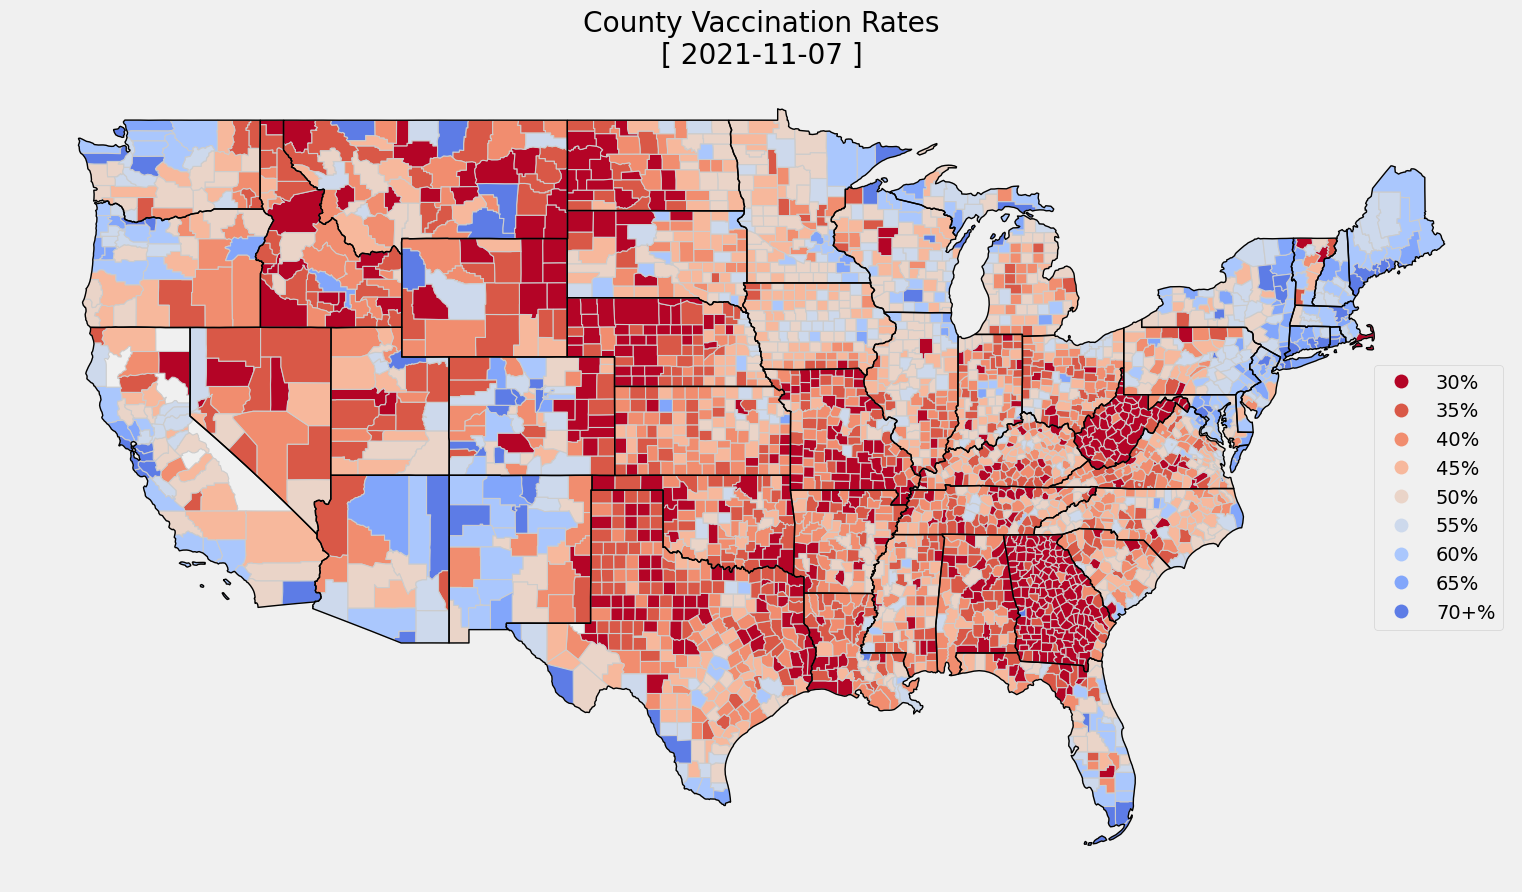

'C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/z_blog_natl_county_vax.jpg'

In [29]:
plot_df = geo_county_tier_df.copy()

plt.rcdefaults()
plt.style.use('fivethirtyeight')

#//*** Scale the plot to county_summary_df tiers.
#//*** Tiers outside of scope will be binned as max and min values
plot_df['tier'] = plot_df['tier'].str.replace("total_","").astype(int)


max_tier = county_summary_df['tier'].str.replace("total_","").astype(int).max()
min_tier = county_summary_df['tier'].str.replace("total_","").astype(int).min()


plot_df.loc[plot_df["tier"] < min_tier,'tier']=min_tier
plot_df.loc[plot_df["tier"] > max_tier,'tier']=max_tier

plot_df = plot_df.sort_values('tier').reset_index()

#print(plot_df['tier'].unique()[1])
#plot_df = plot_df.sort_values('tier')
plot_df['tier'] = plot_df['tier'].astype(str)
#plot_df['tier'] = plot_df['tier'].str.replace(str(min_tier),"\\< 35")

plot_df['tier'] = plot_df['tier'] + "%"
plot_df['tier'] = plot_df['tier'].str.replace("70%","70+%")
#plot_df['tier'] = plot_df['tier'].str.replace("total_5%","total_05%")


#//*** Assign column to graph
plot_column = 'tier'

#//*** Assign Categories for color palettes
plot_cats = plot_df[plot_column].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Blues(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

labels=plot_label_dict.values()


labels=list(plot_label_dict.values())
labels=list(plot_cats)

vax_dist_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()].sort_values('Name')

ax = plot_df.plot(column='tier', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')

#//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=1,edgecolor='black',color=(1,1,1,0),ax=ax)

ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"County Vaccination Rates\n[ {summer_county_tier_df['Date'].max()} ]")

fig = plt.gcf()
fig.set_size_inches(20,10)


leg = ax.get_legend()


print(dir(leg.get_figure))
print(dir(leg))



leg.set_bbox_to_anchor((1,0.65,0,0))

#print(ax.legend())
#//*** Handles is taken from earlie
#plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)
#plt.legend(plt.legend().legendHandles)


outfilename=f'z_blog_natl_county_vax.jpg'
              
#out_blog_images.append(outfilename)
fig.savefig(outfilename)

#out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()
#plot_df['tier'] = plot_df['tier'].replace("total_","")



#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"
copy_path = "wk09_10/"
shutil.copyfile(outfilename, f'{directory_path}{copy_path}{outfilename.split("/")[-1]}')



In [30]:
geo_county_tier_df

STATEFP  GEOID      NAME                                           geometry   FIPS      tier
0          37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  37017  total_40
1          37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  37167  total_35
2          39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...  39153  total_55
3          42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...  42113  total_45
4          48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...  48459  total_30
...       ...    ...       ...                                                ...    ...       ...
3094       22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...  22003  total_30
3095       38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...  38005  total_45
3096       31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...  31159  total_45
3097       37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  37023  total_40
3098       13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...  13261  total_35

[3099 rows x 6 columns]

In [31]:
#datetime.strptime(col, "%m/%d/%y").date()
start_summer_date =  datetime(2021, 7, 1).date()
type(whole_county_tier_df['Date'].iloc[0])
start_days = (start_summer_date - county_summary_df['date_start'].min()).days
summer_days = (county_summary_df['date_end'].max() - start_summer_date).days


print(start_days,summer_days)


county_analysis_dict = {
    'start_daily_100k_confirm' : start_summary_df['confirm_period_100k'].astype(int),
    'start_daily_100k_confirm_min' : start_summary_df['confirm_period_100k'].astype(int).min(),
    'start_daily_100k_confirm_max' : start_summary_df['confirm_period_100k'].astype(int).max(),
    'start_daily_mean_confirm' : start_summary_df['confirm_period'] / start_days,
    'summer_daily_mean_confirm': summer_summary_df['confirm_period'] / summer_days,
    'start_daily_mean_death' : start_summary_df['confirm_deaths'] / start_days,
    'summer_daily_mean_death': summer_summary_df['confirm_deaths'] / summer_days,
    'Population' : start_summary_df['Population'].apply(lambda x: f'{x:,}'),
    
    'pop_pct' : round(start_summary_df['pop_pct']*100,1).astype(str)+"%",
    
    'start_day_count' : start_days,
    'summer_day_count' : summer_days,
    'total_day_count' : start_days + summer_days,
    'us_total_vax' : vax_df['Series_Complete_Pop_Pct'].max(),

}

county_analysis_dict['case_change'] =  round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm']))*100,1)
county_analysis_dict['death_change'] = round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death']))*100,1)

county_analysis_dict['case_baseline'] = pd.Series(round( (1- county_analysis_dict['case_change'] /county_analysis_dict['case_change'][0])*100,1))
county_analysis_dict['death_baseline'] = pd.Series(round( (1- county_analysis_dict['death_change']/county_analysis_dict['death_change'][0])*100,1))

county_analysis_dict['case_change'] = county_analysis_dict['case_change'].astype(str)+'%'
county_analysis_dict['death_change'] = county_analysis_dict['death_change'].astype(str)+'%'
"""
print(start_summary_df['confirm_period'] / start_days)
print(summer_summary_df['confirm_period'] / summer_days)

print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm'])))

print(start_summary_df['confirm_deaths'] / start_days)
print(summer_summary_df['confirm_deaths'] / summer_days)
print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death'])))
"""
manage_df['county_analysis_dict'] = "Summary Stats for Display for the blog post"
county_analysis_dict

511 129


{'start_daily_100k_confirm': 0    10239
 1    10881
 2    10549
 3    10758
 4    10559
 5     9667
 6    10137
 7     9662
 8     9275
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 9275,
 'start_daily_100k_confirm_max': 10881,
 'start_daily_mean_confirm': 0     3631.091977
 1     3562.459883
 2     4677.622309
 3     7350.547945
 4    12211.228963
 5     9829.117417
 6    13879.645793
 7     4573.590998
 8     5151.726027
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 9      7014.449612
 10     7219.472868
 11     9364.937984
 12    12478.573643
 13    19821.100775
 14    14800.418605
 15    16003.844961
 16     4311.844961
 17     5342.441860
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     69.657534
 1     68.929550
 2     88.183953
 3    129.530333
 4    197.814090
 5    151.735812
 6    268.424658
 7     87.614481
 8    100.589041
 Name: confirm_deaths, dtype: float64,
 'summer_daily_mean_death': 9     108.2

In [32]:
county_analysis_dict

{'start_daily_100k_confirm': 0    10239
 1    10881
 2    10549
 3    10758
 4    10559
 5     9667
 6    10137
 7     9662
 8     9275
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 9275,
 'start_daily_100k_confirm_max': 10881,
 'start_daily_mean_confirm': 0     3631.091977
 1     3562.459883
 2     4677.622309
 3     7350.547945
 4    12211.228963
 5     9829.117417
 6    13879.645793
 7     4573.590998
 8     5151.726027
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 9      7014.449612
 10     7219.472868
 11     9364.937984
 12    12478.573643
 13    19821.100775
 14    14800.418605
 15    16003.844961
 16     4311.844961
 17     5342.441860
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     69.657534
 1     68.929550
 2     88.183953
 3    129.530333
 4    197.814090
 5    151.735812
 6    268.424658
 7     87.614481
 8    100.589041
 Name: confirm_deaths, dtype: float64,
 'summer_daily_mean_death': 9     108.2

In [33]:
state_hosp_tiers_df

population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc                 FIPS      tier total_beds beds_used  \
5920    4157971 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5921    4157971 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5922    4157971 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5923    4157971 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5924    4157971 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
...         ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..                  ...       ...        ...       ...   
3931   13485352 2021-11-03     32238     1585367      5964         89     5078.285714     37.657791        45.142857       0.334755  CT  [9, 23, 25, 44, 50]  total_70    33239.0   28119.0   
3932   13485352 2021-11-04     32271     1589090      6753         72     5390.285714     39.971413        47.285714       0.350645  CT  [9, 23, 25, 44, 50]  total_70    33550.0   28133.0   
3933   13485352 2021-11-05     32313     1592433      7066         75     5529.714286     41.005339        50.428571       0.373951  CT  [9, 23, 25, 44, 50]  total_70    33484.0   28043.0   
3934   13485352 2021-11-06     32317     1593395      4305         46     5422.428571     40.209767        52.000000       0.385604  CT  [9, 23, 25, 44, 50]  total_70    33382.0   27641.0   
3935   13485352 2021-11-07     32317     1593800      1367          4     5476.142857     40.608082        52.000000       0.385604  CT  [9, 23, 25, 44, 50]  total_70    33368.0   27337.0   

     covid_beds_used icu_total            icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
5920             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5921             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5922             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5923             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5924             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
...              ...       ...                 ...       ...              ...             ...              ...               ...  
3931          1015.0    2901.0   0.660793031879115     306.0           1001.0            14.0        37.657791          0.334755  
3932          1024.0    2911.0  0.7092034822607179     309.0           1013.0            11.0        39.971413          0.350645  
3933          1049.0    2921.0   0.639455748739269     302.0           1030.0            19.0        41.005339          0.373951  
3934          1032.0    2905.0   0.618700048838922     293.0           1013.0            19.0        40.209767          0.385604  
3935          1020.0    2918.0   0.644444994948072     295.0            997.0            23.0        40.608082          0.385604  

[4480 rows x 23 columns]

In [34]:
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)

#//*** Keep Relevant Data
vax_df = vax_df[cols]

vax_df = vax_df[vax_df["Location"] == 'US' ]
#vax_df['Date'] = 
vax_df['Date'] = pd.to_datetime(vax_df['Date'])

vax_df = vax_df.sort_values('Date')

out_stats

out_stats['total_vaccinated_count'] = format (vax_df.iloc[-1]["Series_Complete_Yes"],',d')
out_stats['total_vaccinated_percent'] = f"{vax_df.iloc[-1]['Series_Complete_Pop_Pct']}%"
out_stats['first_dose_count'] = format (vax_df.iloc[-1]["Administered_Dose1_Recip"],',d')
out_stats['first_dose_percent'] = f"{vax_df.iloc[-1]['Administered_Dose1_Pop_Pct']}%"

manage_df['vax_df'] = "United States Total Vaccine Levels [2020-12-13 - Present]"
vax_df

Date Location  Administered_Dose1_Recip  Administered_Dose1_Pop_Pct  Administered_Dose1_Recip_12Plus  Administered_Dose1_Recip_12PlusPop_Pct  Administered_Dose1_Recip_18Plus  \
21398 2020-12-13       US                         0                         0.0                                0                                     0.0                                0   
21336 2020-12-14       US                         0                         0.0                                0                                     0.0                                0   
21291 2020-12-15       US                         0                         0.0                                0                                     0.0                                0   
21241 2020-12-16       US                         0                         0.0                                0                                     0.0                                0   
21186 2020-12-17       US                         0                         0.0                                0                                     0.0                                0   
...          ...      ...                       ...                         ...                              ...                                     ...                              ...   
279   2021-11-04       US                 222591394                        67.0                        222357053                                    78.4                        207344425   
212   2021-11-05       US                 222902939                        67.1                        222656537                                    78.5                        207630146   
164   2021-11-06       US                 223245121                        67.2                        222965329                                    78.6                        207920448   
80    2021-11-07       US                 223629671                        67.4                        223297591                                    78.8                        208233040   
41    2021-11-08       US                 223944369                        67.5                        223546501                                    78.8                        208465373   

       Administered_Dose1_Recip_18PlusPop_Pct  Administered_Dose1_Recip_65Plus  Administered_Dose1_Recip_65PlusPop_Pct  Series_Complete_Yes  Series_Complete_Pop_Pct  Series_Complete_12Plus  \
21398                                     0.0                                0                                     0.0                    0                      0.0                       0   
21336                                     0.0                                0                                     0.0                    0                      0.0                       0   
21291                                     0.0                                0                                     0.0                    0                      0.0                       0   
21241                                     0.0                                0                                     0.0                    0                      0.0                       0   
21186                                     0.0                                0                                     0.0                    0                      0.0                       0   
...                                       ...                              ...                                     ...                  ...                      ...                     ...   
279                                      80.3                         53518351                                    97.6            193227813                     58.2               193091922   
212                                      80.4                         53595063                                    97.8            193425862                     58.3               193289907   
164            

- [Graph Interactive: U.S. Vaccinations](#graph_us_vaccinations_by_state)


<a id="graph_us_vaccinations_by_state"></a> 
# Graph: U.S. Vaccinations #

- [Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive)](#graph_total_us_vaccination_full_and_partial)


<a id="graph_total_us_vaccination_full_and_partial"></a> 
# Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive) #

- [Graph: List States by Highest Current Death rates (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_death_rates"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: US Total New Deaths Per Day (Line Plot)](#graph_US_total_new_deaths_per_day)


<a id="graph_US_total_new_deaths_per_day"></a> 
# Graph: US Total New Deaths Per Day (Line Plot) #

- [Graph: List States by Highest New Cases (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_new_cases"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: Table of States with Highest Total COVID Counts (Table Plot)](#graph_list_states_highest_total_cases)


<a id="graph_list_states_highest_total_cases"></a> 
# Graph: Table of States with Highest Total COVID Counts (Table Plot) #

- [Graph: U.S. Total COVID Cases Trend (Line Plot)](#graph_us_total_covid_cases_trend)


<a id="graph_us_total_covid_cases_trend"></a> 
# Graph: U.S. Total COVID Cases Trend (Line Plot) #

In [35]:
#plt.get_cmap("Blues")
#//*** Assign Categories for color palettes
plot_cats = geo_county_tier_df['tier'].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


alt_colors = {}
counter = 0
for period in plot_cats:
    alt_colors[period] = colors_palette[counter]
    counter+=1
    
alt_colors


{'total_40': (0.705673158, 0.01555616, 0.150232812, 1.0),
 'total_35': (0.8523781350078431,
  0.34649194649411763,
  0.2803464686980392,
  1.0),
 'total_55': (0.9440545734235294, 0.5531534787490197, 0.4355484903137255, 1.0),
 'total_45': (0.968203399, 0.7208441, 0.6122929913333334, 1.0),
 'total_30': (0.9193759889058823, 0.8312727235294118, 0.7828736304470588, 1.0),
 'total_50': (0.8049647588235295, 0.8516661605568627, 0.9261650744313725, 1.0),
 'total_70': (0.6672529243333334, 0.7791764569999999, 0.992959213, 1.0),
 'total_60': (0.5108243242509803, 0.6493966148235294, 0.9850787763764707, 1.0),
 'total_65': (0.3634607953411765, 0.4847836818509804, 0.9010188868941177, 1.0)}

In [36]:
#tier.replace("total_","")+"%"
colors
if 'geometry' not in geo_county_vax_tier_df.columns:
    print("Merge Geo Data with vax")


    geo_county_vax_tier_df = geo_county_tier_df[["STATEFP","GEOID","geometry"]].merge(geo_county_vax_tier_df,left_on='GEOID',right_on='FIPS')

Merge Geo Data with vax


In [37]:
#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')
if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []
start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in dates:
        
        if datetime.strptime(date, "%m/%d/%y").date() < start_plot_date:
            continue
        #print(date)
        #if date != "1/13/21":
        #    continue
        
        file_counter += 1
        
        #if file_counter % 50 > 0:
        #    continue

        save_filename = f"{filepath}confirm_hist_{file_counter}.jpg"
        death_filename = f"{filepath}death_hist_{file_counter}.jpg"
        vax_filename = f"{filepath}vax_hist_{file_counter}.jpg"
        
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                #print(f"Skipping: {save_filename}")
                out_controls['copy_files']['infographic_cases'].append(save_filename)
                out_controls['copy_files']['infographic_cases'].append(death_filename)
                out_controls['copy_files']['infographic_cases'].append(vax_filename)
                
                continue

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()

        fig.set_size_inches(8,4)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_confirm_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(save_filename)
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 95})

        plt.close()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_death_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(death_filename)
        print(death_filename)
        plt.savefig(death_filename,pil_kwargs={'quality': 90})

        plt.close()
        

        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=70))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"Completed Vaccination",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(vax_filename)
        print(vax_filename)
        plt.savefig(vax_filename,pil_kwargs={'quality': 95})

        plt.close()



    print("Done...")
plt.rcdefaults()

print("Done!")

Working...
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/confirm_hist_640.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/death_hist_640.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/vax_hist_640.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/confirm_hist_641.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/death_hist_641.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/vax_hist_641.jpg
Done...
Done!


In [38]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"

"""
for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")
"""

for key,action in out_controls.items():
    
    
    if key == 'copy_files':
        
        for action_key,action_values in action.items():
            if action_key == "infographic_cases":
                copy_path = "wk09_10/infographic_gifs/"
                
                for filename in action_values:
                    try:
                        print(f'{directory_path}{copy_path}{filename.split("/")[-1]}')
                        shutil.copyfile(filename, f'{directory_path}{copy_path}{filename.split("/")[-1]}')
                    except:
                        continue
                

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_1.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_1.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_1.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_2.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_2.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_2.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_3.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_3.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_3.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_4.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_4.jpg
C:/Users

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_56.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_56.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_57.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_57.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_57.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_58.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_58.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_58.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_59.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_59.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_59.jpg
C

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_91.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_92.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_92.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_92.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_93.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_93.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_93.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_94.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_94.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_94.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_95.jpg

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_127.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_127.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_127.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_128.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_128.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_128.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_129.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_129.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_129.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_130.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_163.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_164.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_164.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_164.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_165.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_165.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_165.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_166.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_166.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_166.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_h

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_199.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_199.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_199.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_200.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_200.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_200.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_201.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_201.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_201.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_202.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_235.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_235.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_235.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_236.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_236.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_236.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_237.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_237.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_237.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_238.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_272.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_272.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_272.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_273.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_273.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_273.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_274.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_274.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_274.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_275.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_306.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_307.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_307.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_307.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_308.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_308.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_308.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_309.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_309.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_309.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_h

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_362.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_362.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_362.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_363.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_363.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_363.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_364.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_364.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_364.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_365.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_415.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_416.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_416.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_416.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_417.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_417.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_417.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_418.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_418.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_418.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_h

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_470.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_470.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_471.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_471.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_471.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_472.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_472.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_472.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_473.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_473.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_his

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_526.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_526.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_526.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_527.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_527.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_527.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_528.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_528.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_528.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_529.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_578.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_578.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_579.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_579.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_579.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_580.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_580.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_580.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_581.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_581.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_his

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_632.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_633.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_633.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_633.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_634.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_634.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_634.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_635.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_635.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_635.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_h

In [39]:
all_dates

['1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20',
 '3/24/20',
 '3/25/20',
 '3/26/20',
 '3/27/20',
 '3/28/20',
 '3/29/20',
 '3/30/20',
 '3/31/20',
 '4/1/20',
 '4/2/20',
 '4/3/20',
 '4/4/20',
 '4/5/20',
 '4/6/20',
 '4/7/20',
 '4/8/20',
 '4/9/20',
 '4/10/20',
 '4/11/20',
 '4/12/20',
 '4/13/20',
 '4/14/20',
 '4/15/20',
 '4/16/20',
 '4/17/20',
 '4/18/20',
 '4/19/20',
 '4/20/20',
 '4/21/20',
 '4/22/20',
 '4/23/

Working...


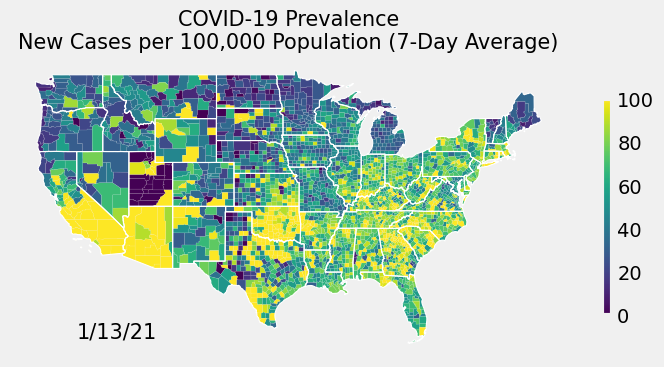

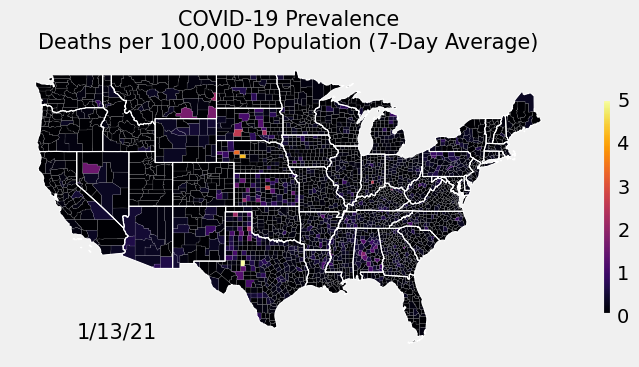

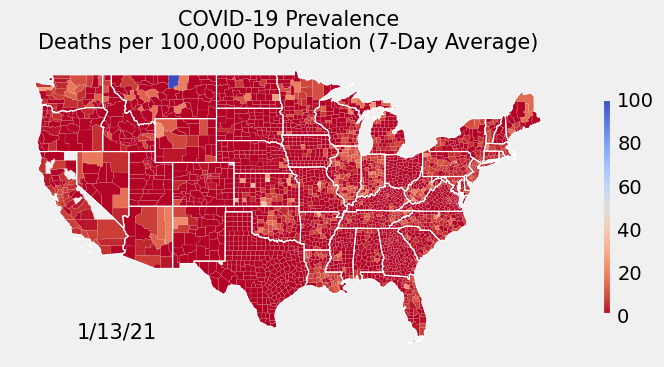

Done...
Done!


In [40]:
#2021/01/13


("1/13/21" in all_dates)



#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')
if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []
start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in ["1/13/21"]:
        

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.savefig("test.jpg",pil_kwargs={'quality': 95})
        plt.show()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.show()
     #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.show()



    print("Done...")
plt.rcdefaults()

print("Done!")

In [41]:
"""
linewidth=.2
counter = 0
for tier in geo_county_tier_df['tier'].unique():
    counter += 1
    temp_plot = geo_county_tier_df[geo_county_tier_df['tier'] == tier]

    if counter > 3:
        linewidth+=.2


    ax = temp_plot.plot(categorical=True,legend=True, linewidth=linewidth,edgecolor=alt_colors[tier],color=(1,1,1,0),ax=ax)

#geo_county_tier_df

temp_plot = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]

if len(temp_plot) > 0:
    #ax = temp_plot.plot(column="total_vaccinated_count",categorical=True,legend=True, linewidth=linewidth,cmap=plt.get_cmap("viridis"),color=(1,1,1,0),ax=ax)
    ax = temp_plot.plot(column="total_vaccinated_count",categorical=True,legend=True, marker='.', linewidth=linewidth,cmap=plt.get_cmap("Blues"),markersize=1,ax=ax)
"""

geo_county_vax_tier_df
print(attrib_death_df)

     STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  1/29/20_New_Deaths  1/29/20_New_Deaths_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                   0                            0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                   0                            0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                   0                            0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                   0                            0   
4         48  48459    Up

In [42]:
attrib_confirm_df['1/5/21_scaled_100k'].max()

100

In [43]:


#//********************************************
#//*** Build Confirmed Historical Slider Plot
#//********************************************
plot_df = attrib_confirm_df.copy()
    

slider_columns = [f"{x}_scaled_100k" for x in all_dates]

slider_range = all_dates
slider_range = [i for i in range(0,len(all_dates))]

#hover_cols = ["Population","Loc"]
#for x in [x*(int(len(all_dates)/8)) for x in range(1,9)]:
#    hover_cols.append(f"{all_dates[x]}_New_Cases")
#    hover_cols.append(f"{all_dates[x]}_New_Cases_per_100k")
hover_cols = ["Population","Loc"]

tooltips =[
   ("index", "$index"),    
   ( "Date",  "@Date" ),
   ("Value", "$y{0}/Day"),
]

slider_name = "COVID Day"

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x*2, med_figsize_y*2),
    #category="scale_100k",
    title = f"U.S. COVID Prevalence (Cases per 100k Population): {all_dates[0]} - {all_dates[-1]}",
    slider=slider_columns,
    slider_range = slider_range,
    slider_name = slider_name,
    toolbar_location=None,
    #title = "TITLE HERE",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    colormap="Viridis",
    #colormap="Inferno",
    hovertool_columns=hover_cols,
    #tooltips=tooltips,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
#out_plot['confirm_historical'] = out_html

In [44]:
county_tier_df

Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
334  2020-12-21  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577     1008949      17046       16167        106    22561.571429   
335  2020-12-22  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577     1022498      17254       20496        253    22665.714286   
336  2020-12-23  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577     1035030      17446       26081        400    22813.285714   
337  2020-12-24  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577     1049309      17619       26811        365    22980.714286   
338  2020-12-25  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577     1057099      17715       22069        269    22217.428571   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
651  2021-11-03  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3310538      54320        6714         87     7649.000000   
652  2021-11-04  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3314948      54376        8123        108     7680.714286   
653  2021-11-05  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3320370      54427        9832        107     7658.857143   
654  2021-11-06  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3321602      54435        6654         59     7602.714286   
655  2021-11-07  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3322526      54441        2156         14     7345.571429   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k total_vaccinated_percent total_vaccinated_count first_dose_pct first_dose_count      tier  
334       274.000000    124.508019       1.512093              100          1.512093                      0.0                      0            0.0              0.0  total_30  
335       274.285714     125.08274        1.51367              100           1.51367                      0.0                      0            0.0              0.0  total_30  
336       279.285714    125.897126       1.541263              100          1.541263                      0.0                      0            0.0              0.0  total_30  
337       278.142857    126.821096       1.534956              100          1.534956                      0.0                      0            0.0              0.0  total_30  
338       272.000000    122.608836       1.501056              100          1.501056                      0.0                      0            0.0              0.0  total_30  
..               ...           ...            ...              ...               ...                      ...                    ...            ...              ...       ...  
651        62.285714     26.950047       0.219454        26.950047          0.219454                73.357855               20820529       82.07954       23295930.0  total_70  
652        66.285714     27.061787       0.233547        27.061787          0.233547                73.428233               20840504      82.175685       23323218.0  total_70  
653        69.285714     26.984777       0.244117        26.984777          0.244117                73.481845               20855720      82.265478       23348703.0  total_7

- [Graph: Infographic Visualization](#infographic_visualization)


<a id="infographic_visualization"></a> 
# Graph: Infographic Visualization #

In [45]:
geo_county_vax_tier_df['Date'].iloc[1]

datetime.date(2021, 11, 7)

In [46]:
import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()
    
out_master = {}

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily","total_vaccinated_percent"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in whole_county_tier_df['Date'].unique():
    #if date >= start_summer_date:
    #    break
    loop_df = whole_county_tier_df[whole_county_tier_df['Date'] == date].copy()
    loop_vax_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == date].copy()
    
   
    
    
    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_confirm)
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = round(new_confirm / (pop / 100000),4)
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                
                case_100k_avg_daily = round(tot_confirm / (pop / 100000),4)
                case_100k_avg_daily = round(case_100k_avg_daily / days,4)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = round(new_deaths / (pop / 100000),4)
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,2)
                td[col].append(death_100k_avg_daily)
                continue
                
            if col == "total_vaccinated_percent":
                #//**** No Vaccaination Data Yet
                #loop_vax_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == date]
                #total_vaccinated_percent = "0%"
                #td[col].append("0%")
                if len(loop_vax_df) == 0:
                    total_vaccinated_percent = "0.0%"
                    td[col].append("0%")
                else:
                    #print(geo_county_vax_tier_df)
                    
                    total_vaccinated_percent = loop_vax_df[loop_vax_df['tier'] == tier][col].values[0]
                    total_vaccinated_percent = str(total_vaccinated_percent) + "%"
                    td[col].append(total_vaccinated_percent)
                continue

    #print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm,total_vaccinated_percent)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['New_Confirm'][x],td['tier'][x],td['case_100k_avg'][x],td["relative_confirm_100k"][x],td['total_vaccinated_percent'][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_left'] = {
    'filename' : 'infographic_left.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_left = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
last_date = td['Date'][-1]
print("Done!")

0 2020/02/06 total_30 0 total_30 0.0 0% 0%
1 2020/02/06 total_35 0 total_35 0.0 0% 0%
2 2020/02/06 total_40 0 total_40 0.0 0% 0%
3 2020/02/06 total_45 0 total_45 0.0 0% 0%
4 2020/02/06 total_50 0 total_50 0.0 0% 0%
5 2020/02/06 total_55 0 total_55 0.0 0% 0%
6 2020/02/06 total_60 1 total_60 0.0014 0% 0%
7 2020/02/06 total_65 0 total_65 0.0 0% 0%
8 2020/02/06 total_70 0 total_70 0.0 0% 0%
9 2020/02/07 total_30 0 total_30 0.0 0% 0%
10 2020/02/07 total_35 0 total_35 0.0 0% 0%
11 2020/02/07 total_40 0 total_40 0.0 0% 0%
12 2020/02/07 total_45 0 total_45 0.0 0% 0%
13 2020/02/07 total_50 0 total_50 0.0 0% 0%
14 2020/02/07 total_55 0 total_55 0.0 0% 0%
15 2020/02/07 total_60 1 total_60 0.0014 0% 0%
16 2020/02/07 total_65 0 total_65 0.0 0% 0%
17 2020/02/07 total_70 0 total_70 0.0 0% 0%
18 2020/02/08 total_30 0 total_30 0.0 0% 0%
19 2020/02/08 total_35 0 total_35 0.0 0% 0%
20 2020/02/08 total_40 0 total_40 0.0 0% 0%
21 2020/02/08 total_45 0 total_45 0.0 0% 0%
22 2020/02/08 total_50 0 total_50 0.

330 2020/03/13 total_60 244 total_60 0.3488 315.94% 0%
331 2020/03/13 total_65 125 total_65 0.5168 468.12% 0%
332 2020/03/13 total_70 358 total_70 1.2614 1142.57% 0%
333 2020/03/14 total_30 38 total_30 0.2097 100.0% 0%
334 2020/03/14 total_35 24 total_35 0.1435 68.43% 0%
335 2020/03/14 total_40 24 total_40 0.1059 50.5% 0%
336 2020/03/14 total_45 32 total_45 0.0917 43.73% 0%
337 2020/03/14 total_50 121 total_50 0.2048 97.66% 0%
338 2020/03/14 total_55 130 total_55 0.2502 119.31% 0%
339 2020/03/14 total_60 357 total_60 0.5103 243.35% 0%
340 2020/03/14 total_65 158 total_65 0.6532 311.49% 0%
341 2020/03/14 total_70 402 total_70 1.4164 675.44% 0%
342 2020/03/15 total_30 54 total_30 0.298 100.0% 0%
343 2020/03/15 total_35 24 total_35 0.1435 48.15% 0%
344 2020/03/15 total_40 18 total_40 0.0794 26.64% 0%
345 2020/03/15 total_45 19 total_45 0.0544 18.26% 0%
346 2020/03/15 total_50 99 total_50 0.1675 56.21% 0%
347 2020/03/15 total_55 121 total_55 0.2329 78.15% 0%
348 2020/03/15 total_60 292 tot

607 2020/04/13 total_50 3886 total_50 6.5762 68.68% 0%
608 2020/04/13 total_55 6405 total_55 12.3283 128.76% 0%
609 2020/04/13 total_60 17066 total_60 24.3934 254.77% 0%
610 2020/04/13 total_65 8294 total_65 34.2905 358.13% 0%
611 2020/04/13 total_70 10679 total_70 37.6258 392.97% 0%
612 2020/04/14 total_30 2490 total_30 13.7413 100.0% 0%
613 2020/04/14 total_35 1107 total_35 6.6173 48.16% 0%
614 2020/04/14 total_40 1425 total_40 6.2891 45.77% 0%
615 2020/04/14 total_45 3298 total_45 9.446 68.74% 0%
616 2020/04/14 total_50 3715 total_50 6.2869 45.75% 0%
617 2020/04/14 total_55 6341 total_55 12.2052 88.82% 0%
618 2020/04/14 total_60 17015 total_60 24.3205 176.99% 0%
619 2020/04/14 total_65 9049 total_65 37.412 272.26% 0%
620 2020/04/14 total_70 9880 total_70 34.8106 253.33% 0%
621 2020/04/15 total_30 2108 total_30 11.6332 100.0% 0%
622 2020/04/15 total_35 1032 total_35 6.169 53.03% 0%
623 2020/04/15 total_40 1488 total_40 6.5671 56.45% 0%
624 2020/04/15 total_45 3440 total_45 9.8527 84.

892 2020/05/15 total_35 2281 total_35 13.6351 147.24% 0%
893 2020/05/15 total_40 2202 total_40 9.7183 104.95% 0%
894 2020/05/15 total_45 4026 total_45 11.5311 124.52% 0%
895 2020/05/15 total_50 6927 total_50 11.7225 126.59% 0%
896 2020/05/15 total_55 7584 total_55 14.5977 157.64% 0%
897 2020/05/15 total_60 14686 total_60 20.9915 226.69% 0%
898 2020/05/15 total_65 6541 total_65 27.043 292.03% 0%
899 2020/05/15 total_70 4743 total_70 16.7112 180.46% 0%
900 2020/05/16 total_30 1224 total_30 6.7548 100.0% 0%
901 2020/05/16 total_35 2528 total_35 15.1116 223.72% 0%
902 2020/05/16 total_40 2417 total_40 10.6672 157.92% 0%
903 2020/05/16 total_45 3588 total_45 10.2766 152.14% 0%
904 2020/05/16 total_50 6398 total_50 10.8273 160.29% 0%
905 2020/05/16 total_55 6980 total_55 13.4351 198.9% 0%
906 2020/05/16 total_60 13873 total_60 19.8294 293.56% 0%
907 2020/05/16 total_65 6337 total_65 26.1995 387.86% 0%
908 2020/05/16 total_70 4540 total_70 15.996 236.81% 0%
909 2020/05/17 total_30 703 total_3

1190 2020/06/17 total_40 2956 total_40 13.046 78.75% 0%
1191 2020/06/17 total_45 5259 total_45 15.0626 90.92% 0%
1192 2020/06/17 total_50 11799 total_50 19.9673 120.53% 0%
1193 2020/06/17 total_55 6898 total_55 13.2773 80.14% 0%
1194 2020/06/17 total_60 12066 total_60 17.2466 104.1% 0%
1195 2020/06/17 total_65 1946 total_65 8.0455 48.56% 0%
1196 2020/06/17 total_70 3543 total_70 12.4832 75.35% 0%
1197 2020/06/18 total_30 3009 total_30 16.6054 100.0% 0%
1198 2020/06/18 total_35 3685 total_35 22.0278 132.65% 0%
1199 2020/06/18 total_40 2974 total_40 13.1254 79.04% 0%
1200 2020/06/18 total_45 5940 total_45 17.0131 102.46% 0%
1201 2020/06/18 total_50 12773 total_50 21.6156 130.17% 0%
1202 2020/06/18 total_55 8146 total_55 15.6794 94.42% 0%
1203 2020/06/18 total_60 12869 total_60 18.3944 110.77% 0%
1204 2020/06/18 total_65 2122 total_65 8.7731 52.83% 0%
1205 2020/06/18 total_70 3778 total_70 13.3112 80.16% 0%
1206 2020/06/19 total_30 3062 total_30 16.8979 100.0% 0%
1207 2020/06/19 total_35 

1482 2020/07/19 total_60 27274 total_60 38.9842 89.03% 0%
1483 2020/07/19 total_65 3956 total_65 16.3556 37.35% 0%
1484 2020/07/19 total_70 10660 total_70 37.5588 85.77% 0%
1485 2020/07/20 total_30 6455 total_30 35.6225 100.0% 0%
1486 2020/07/20 total_35 7593 total_35 45.3885 127.42% 0%
1487 2020/07/20 total_40 7814 total_40 34.4863 96.81% 0%
1488 2020/07/20 total_45 12955 total_45 37.1052 104.16% 0%
1489 2020/07/20 total_50 26937 total_50 45.5852 127.97% 0%
1490 2020/07/20 total_55 15733 total_55 30.2829 85.01% 0%
1491 2020/07/20 total_60 26582 total_60 37.9951 106.66% 0%
1492 2020/07/20 total_65 3468 total_65 14.338 40.25% 0%
1493 2020/07/20 total_70 9947 total_70 35.0467 98.38% 0%
1494 2020/07/21 total_30 7411 total_30 40.8983 100.0% 0%
1495 2020/07/21 total_35 8345 total_35 49.8837 121.97% 0%
1496 2020/07/21 total_40 9068 total_40 40.0207 97.85% 0%
1497 2020/07/21 total_45 15222 total_45 43.5983 106.6% 0%
1498 2020/07/21 total_50 29254 total_50 49.5063 121.05% 0%
1499 2020/07/21 to

1777 2020/08/21 total_50 16994 total_50 28.7588 61.72% 0%
1778 2020/08/21 total_55 13251 total_55 25.5055 54.74% 0%
1779 2020/08/21 total_60 15892 total_60 22.7153 48.75% 0%
1780 2020/08/21 total_65 4080 total_65 16.8683 36.2% 0%
1781 2020/08/21 total_70 6108 total_70 21.5206 46.19% 0%
1782 2020/08/22 total_30 7804 total_30 43.0671 100.0% 0%
1783 2020/08/22 total_35 6207 total_35 37.1035 86.15% 0%
1784 2020/08/22 total_40 7616 total_40 33.6124 78.05% 0%
1785 2020/08/22 total_45 11618 total_45 33.2758 77.27% 0%
1786 2020/08/22 total_50 17551 total_50 29.7014 68.97% 0%
1787 2020/08/22 total_55 13924 total_55 26.8009 62.23% 0%
1788 2020/08/22 total_60 15232 total_60 21.7719 50.55% 0%
1789 2020/08/22 total_65 4153 total_65 17.1701 39.87% 0%
1790 2020/08/22 total_70 6492 total_70 22.8735 53.11% 0%
1791 2020/08/23 total_30 5815 total_30 32.0906 100.0% 0%
1792 2020/08/23 total_35 4891 total_35 29.2368 91.11% 0%
1793 2020/08/23 total_40 6203 total_40 27.3763 85.31% 0%
1794 2020/08/23 total_45 

2072 2020/09/23 total_40 9325 total_40 41.1549 116.02% 0%
2073 2020/09/23 total_45 9868 total_45 28.2636 79.68% 0%
2074 2020/09/23 total_50 14552 total_50 24.6262 69.42% 0%
2075 2020/09/23 total_55 12210 total_55 23.5018 66.25% 0%
2076 2020/09/23 total_60 11941 total_60 17.0679 48.11% 0%
2077 2020/09/23 total_65 3290 total_65 13.6021 38.34% 0%
2078 2020/09/23 total_70 4167 total_70 14.6818 41.39% 0%
2079 2020/09/24 total_30 7189 total_30 39.6731 100.0% 0%
2080 2020/09/24 total_35 7487 total_35 44.7549 112.81% 0%
2081 2020/09/24 total_40 8922 total_40 39.3763 99.25% 0%
2082 2020/09/24 total_45 11520 total_45 32.9952 83.17% 0%
2083 2020/09/24 total_50 16224 total_50 27.4557 69.2% 0%
2084 2020/09/24 total_55 13697 total_55 26.364 66.45% 0%
2085 2020/09/24 total_60 11171 total_60 15.9673 40.25% 0%
2086 2020/09/24 total_65 4087 total_65 16.8972 42.59% 0%
2087 2020/09/24 total_70 4560 total_70 16.0664 40.5% 0%
2088 2020/09/25 total_30 7426 total_30 40.981 100.0% 0%
2089 2020/09/25 total_35 7

2353 2020/10/24 total_50 30107 total_50 50.9498 95.86% 0%
2354 2020/10/24 total_55 27489 total_55 52.9108 99.55% 0%
2355 2020/10/24 total_60 26504 total_60 37.8836 71.28% 0%
2356 2020/10/24 total_65 11757 total_65 48.6079 91.46% 0%
2357 2020/10/24 total_70 7442 total_70 26.2207 49.33% 0%
2358 2020/10/25 total_30 8102 total_30 44.7116 100.0% 0%
2359 2020/10/25 total_35 9417 total_35 56.2918 125.9% 0%
2360 2020/10/25 total_40 12983 total_40 57.2991 128.15% 0%
2361 2020/10/25 total_45 18587 total_45 53.2362 119.07% 0%
2362 2020/10/25 total_50 28077 total_50 47.5144 106.27% 0%
2363 2020/10/25 total_55 25280 total_55 48.6589 108.83% 0%
2364 2020/10/25 total_60 22761 total_60 32.5335 72.76% 0%
2365 2020/10/25 total_65 11364 total_65 46.983 105.08% 0%
2366 2020/10/25 total_70 6566 total_70 23.1343 51.74% 0%
2367 2020/10/26 total_30 6140 total_30 33.8841 100.0% 0%
2368 2020/10/26 total_35 8291 total_35 49.5609 146.27% 0%
2369 2020/10/26 total_40 10528 total_40 46.4642 137.13% 0%
2370 2020/10/2

2664 2020/11/28 total_30 13806 total_30 76.1896 100.0% 0%
2665 2020/11/28 total_35 20271 total_35 121.1736 159.04% 0%
2666 2020/11/28 total_40 27653 total_40 122.0436 160.18% 0%
2667 2020/11/28 total_45 43709 total_45 125.1897 164.31% 0%
2668 2020/11/28 total_50 67822 total_50 114.7745 150.64% 0%
2669 2020/11/28 total_55 62256 total_55 119.8303 157.28% 0%
2670 2020/11/28 total_60 65266 total_60 93.2883 122.44% 0%
2671 2020/11/28 total_65 24592 total_65 101.6726 133.45% 0%
2672 2020/11/28 total_70 23501 total_70 82.8021 108.68% 0%
2673 2020/11/29 total_30 11655 total_30 64.3191 100.0% 0%
2674 2020/11/29 total_35 16096 total_35 96.2167 149.59% 0%
2675 2020/11/29 total_40 21809 total_40 96.2517 149.65% 0%
2676 2020/11/29 total_45 33358 total_45 95.5427 148.54% 0%
2677 2020/11/29 total_50 59214 total_50 100.2073 155.8% 0%
2678 2020/11/29 total_55 48430 total_55 93.218 144.93% 0%
2679 2020/11/29 total_60 59908 total_60 85.6298 133.13% 0%
2680 2020/11/29 total_65 20998 total_65 86.8136 134.9

2954 2020/12/30 total_40 34130 total_40 150.6292 94.39% 0.0%
2955 2020/12/30 total_45 50449 total_45 144.4942 90.55% 0.0%
2956 2020/12/30 total_50 75355 total_50 127.5226 79.91% 0.0%
2957 2020/12/30 total_55 53849 total_55 103.6485 64.95% 0.0%
2958 2020/12/30 total_60 93985 total_60 134.3379 84.18% 0.0%
2959 2020/12/30 total_65 25226 total_65 104.2938 65.35% 0.0%
2960 2020/12/30 total_70 26090 total_70 91.924 57.6% 0.0%
2961 2020/12/31 total_30 30321 total_30 167.3291 100.0% 0.0%
2962 2020/12/31 total_35 28032 total_35 167.5663 100.14% 0.0%
2963 2020/12/31 total_40 36119 total_40 159.4074 95.27% 0.0%
2964 2020/12/31 total_45 56219 total_45 161.0204 96.23% 0.0%
2965 2020/12/31 total_50 91704 total_50 155.1898 92.75% 0.0%
2966 2020/12/31 total_55 62015 total_55 119.3664 71.34% 0.0%
2967 2020/12/31 total_60 101990 total_60 145.7799 87.12% 0.0%
2968 2020/12/31 total_65 30785 total_65 127.2768 76.06% 0.0%
2969 2020/12/31 total_70 36047 total_70 127.0059 75.9% 0.0%
2970 2021/01/01 total_30 3

3222 2021/01/29 total_30 20243 total_30 111.7128 100.0% 0.0%
3223 2021/01/29 total_35 17158 total_35 102.565 91.81% 0.6%
3224 2021/01/29 total_40 24180 total_40 106.7159 95.53% 1.0%
3225 2021/01/29 total_45 34534 total_45 98.911 88.54% 2.6%
3226 2021/01/29 total_50 59881 total_50 101.336 90.71% 2.1%
3227 2021/01/29 total_55 48305 total_55 92.9774 83.23% 0.7%
3228 2021/01/29 total_60 73022 total_60 104.3744 93.43% 1.0%
3229 2021/01/29 total_65 21882 total_65 90.4684 80.98% 2.1%
3230 2021/01/29 total_70 26741 total_70 94.2177 84.34% 0.0%
3231 2021/01/30 total_30 18385 total_30 101.4592 100.0% 0.0%
3232 2021/01/30 total_35 14524 total_35 86.8198 85.57% 0.6%
3233 2021/01/30 total_40 20500 total_40 90.4746 89.17% 1.0%
3234 2021/01/30 total_45 31323 total_45 89.7142 88.42% 2.6%
3235 2021/01/30 total_50 55238 total_50 93.4787 92.13% 2.4%
3236 2021/01/30 total_55 43871 total_55 84.4429 83.23% 1.0%
3237 2021/01/30 total_60 69764 total_60 99.7175 98.28% 1.1%
3238 2021/01/30 total_65 19260 total_

3545 2021/03/05 total_70 13752 total_70 48.453 135.31% 4.2%
3546 2021/03/06 total_30 6069 total_30 33.4923 100.0% 0.0%
3547 2021/03/06 total_35 5020 total_35 30.008 89.6% 7.3%
3548 2021/03/06 total_40 7844 total_40 34.6187 103.36% 11.0%
3549 2021/03/06 total_45 11683 total_45 33.462 99.91% 9.6%
3550 2021/03/06 total_50 19773 total_50 33.4617 99.91% 9.7%
3551 2021/03/06 total_55 19235 total_55 37.0235 110.54% 6.3%
3552 2021/03/06 total_60 29421 total_60 42.0531 125.56% 6.8%
3553 2021/03/06 total_65 10633 total_65 43.9608 131.26% 15.8%
3554 2021/03/06 total_70 13405 total_70 47.2304 141.02% 4.2%
3555 2021/03/07 total_30 5180 total_30 28.5863 100.0% 0.0%
3556 2021/03/07 total_35 3994 total_35 23.8749 83.52% 7.4%
3557 2021/03/07 total_40 5254 total_40 23.188 81.12% 11.2%
3558 2021/03/07 total_45 8466 total_45 24.248 84.82% 9.6%
3559 2021/03/07 total_50 15386 total_50 26.0376 91.08% 9.8%
3560 2021/03/07 total_55 14949 total_55 28.7738 100.66% 6.6%
3561 2021/03/07 total_60 25533 total_60 36.

3792 2021/04/02 total_45 14440 total_45 41.3585 138.4% 17.4%
3793 2021/04/02 total_50 23032 total_50 38.9768 130.43% 22.5%
3794 2021/04/02 total_55 23349 total_55 44.9421 150.39% 12.6%
3795 2021/04/02 total_60 34842 total_60 49.8016 166.65% 14.4%
3796 2021/04/02 total_65 16070 total_65 66.4394 222.33% 24.5%
3797 2021/04/02 total_70 16030 total_70 56.4792 189.0% 15.3%
3798 2021/04/03 total_30 4650 total_30 25.6614 100.0% 0.0%
3799 2021/04/03 total_35 3981 total_35 23.7971 92.74% 10.0%
3800 2021/04/03 total_40 5605 total_40 24.7371 96.4% 15.2%
3801 2021/04/03 total_45 13544 total_45 38.7922 151.17% 17.5%
3802 2021/04/03 total_50 21242 total_50 35.9476 140.08% 23.0%
3803 2021/04/03 total_55 21856 total_55 42.0684 163.94% 13.1%
3804 2021/04/03 total_60 31674 total_60 45.2734 176.43% 15.1%
3805 2021/04/03 total_65 14432 total_65 59.6673 232.52% 25.2%
3806 2021/04/03 total_70 14471 total_70 50.9863 198.69% 16.4%
3807 2021/04/04 total_30 3452 total_30 19.0502 100.0% 0.0%
3808 2021/04/04 total

4111 2021/05/07 total_65 7246 total_65 29.9577 124.54% 43.6%
4112 2021/05/07 total_70 6427 total_70 22.6445 94.13% 41.6%
4113 2021/05/08 total_30 3851 total_30 21.2521 100.0% 0.0%
4114 2021/05/08 total_35 3534 total_35 21.1251 99.4% 14.0%
4115 2021/05/08 total_40 5092 total_40 22.473 105.74% 21.2%
4116 2021/05/08 total_45 8689 total_45 24.8867 117.1% 28.7%
4117 2021/05/08 total_50 15177 total_50 25.6839 120.85% 37.9%
4118 2021/05/08 total_55 13865 total_55 26.6873 125.57% 30.6%
4119 2021/05/08 total_60 17131 total_60 24.4863 115.22% 27.7%
4120 2021/05/08 total_65 6247 total_65 25.8274 121.53% 44.1%
4121 2021/05/08 total_70 6245 total_70 22.0033 103.53% 43.5%
4122 2021/05/09 total_30 2810 total_30 15.5072 100.0% 0.0%
4123 2021/05/09 total_35 2027 total_35 12.1168 78.14% 14.1%
4124 2021/05/09 total_40 3126 total_40 13.7963 88.97% 21.2%
4125 2021/05/09 total_45 4761 total_45 13.6363 87.94% 29.0%
4126 2021/05/09 total_50 10545 total_50 17.8452 115.08% 38.1%
4127 2021/05/09 total_55 9783 to

4374 2021/06/06 total_30 774 total_30 4.2714 100.0% 0.0%
4375 2021/06/06 total_35 595 total_35 3.5567 83.27% 16.1%
4376 2021/06/06 total_40 1098 total_40 4.8459 113.45% 23.0%
4377 2021/06/06 total_45 1726 total_45 4.9435 115.73% 35.4%
4378 2021/06/06 total_50 4169 total_50 7.0552 165.17% 42.5%
4379 2021/06/06 total_55 3324 total_55 6.398 149.79% 36.3%
4380 2021/06/06 total_60 3842 total_60 5.4916 128.57% 36.3%
4381 2021/06/06 total_65 1482 total_65 6.1271 143.44% 51.3%
4382 2021/06/06 total_70 2513 total_70 8.8542 207.29% 55.7%
4383 2021/06/07 total_30 1270 total_30 7.0086 100.0% 0.0%
4384 2021/06/07 total_35 1208 total_35 7.221 103.03% 16.2%
4385 2021/06/07 total_40 1575 total_40 6.9511 99.18% 23.1%
4386 2021/06/07 total_45 2351 total_45 6.7336 96.08% 35.5%
4387 2021/06/07 total_50 4316 total_50 7.3039 104.21% 42.6%
4388 2021/06/07 total_55 3738 total_55 7.1949 102.66% 36.6%
4389 2021/06/07 total_60 2892 total_60 4.1337 58.98% 36.5%
4390 2021/06/07 total_65 1237 total_65 5.1142 72.97%

4667 2021/07/08 total_55 6070 total_55 11.6835 62.01% 40.3%
4668 2021/07/08 total_60 6255 total_60 8.9406 47.45% 43.0%
4669 2021/07/08 total_65 1654 total_65 6.8383 36.3% 56.4%
4670 2021/07/08 total_70 1884 total_70 6.638 35.23% 62.3%
4671 2021/07/09 total_30 3555 total_30 19.6186 100.0% 0.0%
4672 2021/07/09 total_35 3528 total_35 21.0893 107.5% 17.7%
4673 2021/07/09 total_40 6133 total_40 27.0674 137.97% 24.7%
4674 2021/07/09 total_45 5906 total_45 16.9157 86.22% 38.7%
4675 2021/07/09 total_50 15042 total_50 25.4554 129.75% 44.9%
4676 2021/07/09 total_55 8792 total_55 16.9228 86.26% 40.4%
4677 2021/07/09 total_60 13629 total_60 19.4807 99.3% 43.2%
4678 2021/07/09 total_65 1825 total_65 7.5452 38.46% 56.5%
4679 2021/07/09 total_70 6624 total_70 23.3386 118.96% 62.4%
4680 2021/07/10 total_30 2631 total_30 14.5194 100.0% 0.0%
4681 2021/07/10 total_35 2714 total_35 16.2234 111.74% 17.7%
4682 2021/07/10 total_40 4679 total_40 20.6503 142.23% 24.7%
4683 2021/07/10 total_45 4458 total_45 12.

5015 2021/08/16 total_40 25391 total_40 112.0605 89.23% 26.7%
5016 2021/08/16 total_45 33570 total_45 96.1499 76.56% 40.4%
5017 2021/08/16 total_50 45074 total_50 76.2783 60.74% 46.2%
5018 2021/08/16 total_55 30655 total_55 59.0047 46.98% 42.4%
5019 2021/08/16 total_60 37661 total_60 53.8309 42.86% 47.6%
5020 2021/08/16 total_65 9338 total_65 38.6068 30.74% 59.0%
5021 2021/08/16 total_70 11391 total_70 40.1344 31.96% 64.2%
5022 2021/08/17 total_30 32480 total_30 179.2437 100.0% 0.0%
5023 2021/08/17 total_35 26843 total_35 160.4589 89.52% 19.1%
5024 2021/08/17 total_40 34680 total_40 153.0565 85.39% 26.7%
5025 2021/08/17 total_45 45161 total_45 129.3485 72.16% 40.5%
5026 2021/08/17 total_50 62052 total_50 105.01 58.59% 46.2%
5027 2021/08/17 total_55 41771 total_55 80.4008 44.86% 42.4%
5028 2021/08/17 total_60 49051 total_60 70.1113 39.12% 47.7%
5029 2021/08/17 total_65 13437 total_65 55.5536 30.99% 59.1%
5030 2021/08/17 total_70 12504 total_70 44.0559 24.58% 64.3%
5031 2021/08/18 total_

5309 2021/09/17 total_70 20225 total_70 71.2596 51.32% 66.2%
5310 2021/09/18 total_30 17647 total_30 97.3865 100.0% 0.0%
5311 2021/09/18 total_35 19012 total_35 113.6477 116.7% 21.6%
5312 2021/09/18 total_40 25269 total_40 111.5221 114.51% 30.2%
5313 2021/09/18 total_45 32994 total_45 94.5002 97.04% 42.3%
5314 2021/09/18 total_50 59783 total_50 101.1702 103.89% 48.9%
5315 2021/09/18 total_55 41932 total_55 80.7107 82.88% 54.3%
5316 2021/09/18 total_60 50345 total_60 71.9609 73.89% 53.9%
5317 2021/09/18 total_65 10322 total_65 42.675 43.82% 62.4%
5318 2021/09/18 total_70 17078 total_70 60.1716 61.79% 66.3%
5319 2021/09/19 total_30 6916 total_30 38.1666 100.0% 0.0%
5320 2021/09/19 total_35 6190 total_35 37.0018 96.95% 21.7%
5321 2021/09/19 total_40 7843 total_40 34.6143 90.69% 30.3%
5322 2021/09/19 total_45 8668 total_45 24.8266 65.05% 42.5%
5323 2021/09/19 total_50 16429 total_50 27.8026 72.85% 48.9%
5324 2021/09/19 total_55 13530 total_55 26.0425 68.23% 54.5%
5325 2021/09/19 total_60 1

5595 2021/10/19 total_60 30516 total_60 43.6182 79.68% 59.4%
5596 2021/10/19 total_65 12231 total_65 50.5676 92.37% 64.8%
5597 2021/10/19 total_70 8717 total_70 30.713 56.1% 68.2%
5598 2021/10/20 total_30 9697 total_30 53.5137 100.0% 0.0%
5599 2021/10/20 total_35 12602 total_35 75.3307 140.77% 36.4%
5600 2021/10/20 total_40 15689 total_40 69.2418 129.39% 43.8%
5601 2021/10/20 total_45 23680 total_45 67.8234 126.74% 44.7%
5602 2021/10/20 total_50 36177 total_50 61.222 114.4% 50.5%
5603 2021/10/20 total_55 28966 total_55 55.7537 104.19% 56.0%
5604 2021/10/20 total_60 28018 total_60 40.0477 74.84% 59.6%
5605 2021/10/20 total_65 10288 total_65 42.5345 79.48% 64.8%
5606 2021/10/20 total_70 8427 total_70 29.6912 55.48% 68.2%
5607 2021/10/21 total_30 9815 total_30 54.1649 100.0% 0.0%
5608 2021/10/21 total_35 12568 total_35 75.1275 138.7% 36.5%
5609 2021/10/21 total_40 15733 total_40 69.4359 128.19% 43.8%
5610 2021/10/21 total_45 24520 total_45 70.2293 129.66% 44.8%
5611 2021/10/21 total_50 33

Done!


In [47]:
#//*** Assign Categories for color palettes
plot_cats = whole_county_tier_df['tier'].unique()
print(plot_cats)
#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]
#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

ghetto_pal = []
for x in colors_palette:
    ghetto_pal.append(matplotlib.colors.to_hex(x))
    
print(ghetto_pal)

['total_30' 'total_35' 'total_40' 'total_45' 'total_50' 'total_55'
 'total_60' 'total_65' 'total_70']
['#b40426', '#d95847', '#f18d6f', '#f7b89c', '#ead4c8', '#cdd9ec', '#aac7fd', '#82a6fb', '#5d7ce6']


In [48]:
import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"

#//*** Handle out_master fileops
for top_key,top_values in out_master.items():
    if top_key == 'build_json':
        for key,json_dict in top_values.items():
            outpath = directory_path
            if 'path' in json_dict.keys():
                outpath = outpath + json_dict['path']
            
            outpath = outpath + json_dict['filename']
            outpath = outpath.replace("//","/")
            
            print("Writing File:",outpath)
                
            #//*** Write the updated text to file
            with open(outpath , "w") as f:
                f.write(json_dict['data'])
            
            
            




Writing File: C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_left.js


In [49]:
"""
#//*** Hide Output for this Cell only
#%%capture --no-display

def build_df(input_dict,input_field):
    index=list(input_dict[list(input_dict.keys())[0]].keys())
    print(index)
    out_df = pd.DataFrame(index=index)
    
    all_cols = []
    date_cols = []
    for date,fields in input_dict.items():
        #print(date,fields)
        
        val_list = []
        for key,values in fields.items():
            
            val_list.append(values[input_field])
        out_df[date] = pd.Series(val_list,index=index)
        
    
    return out_df
case_100k_df = build_df(out,"case_100k_avg")
print(case_100k_df)
"""
print("Trash?")

Trash?


Bar chart example
https://coderzcolumn.com/tutorials/data-science/interactive-plotting-in-python-using-bokeh

Slider Example
https://docs.bokeh.org/en/latest/docs/first_steps/first_steps_9.html

Javascript Bar chart Canvas
https://code.tutsplus.com/tutorials/how-to-draw-bar-charts-using-javascript-and-html5-canvas--cms-28561

In [50]:
"""
from bokeh.models import Div, Slider
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()
# prepare some data
x1 = [1, 2, 3, 4, 5]
y1 = [6, 7, 2, 4, 5]
y2 = [2, 3, 4, 5, 6]
y3 = [4, 5, 5, 7, 2]

med_figsize_x = 20
med_figsize_y = 10
x=list(case_100k_df.index)
y=list(case_100k_df[case_100k_df.columns[300]])
print(x)
print(y)



fig = figure(plot_width=300, plot_height=300, title="Average mpg per region")

fig.hbar(y=range(len(x)), right=y, left=0, height=0.5, fill_color="#b3de69")


amp_slider = Slider(start=0.1, end=10, value=1, step=.1, title="Amplitude")

#fig.vbar(x = range(len(x)),
#         width=0.5,
#         top=y,
#         fill_color="firebrick", line_color="blue", alpha=0.8)

#fig.xaxis.ticker = list(range(len(x)))

#fig.xaxis.major_label_overrides = {1: 'North America', 2: 'Asia', 3: 'Europe'}
#fig.xaxis.major_label_overrides = dict(enumerate(x))
show(fig)
"""
print("Brokeh!")

Brokeh!


In [51]:
"""
from datetime import timedelta
start_summer_date-timedelta(days=1)

last_counts_dict = {}

for group in whole_county_tier_df[whole_county_tier_df['Date'] == (start_summer_date-timedelta(days=1))].groupby('tier'):
    last_counts_dict[group[0]] = {
        'tot_confirm' : group[1]['tot_confirm'].values[0],
        'tot_deaths' : group[1]['tot_deaths'].values[0],
    }
print(last_counts_dict)


import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in start_avg_daily_county_tier_df['Date'].unique():

    loop_df = start_avg_daily_county_tier_df[start_avg_daily_county_tier_df['Date'] == date]
    

    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = loop_df[loop_df['tier'] == tier][col].values[0]
                
                tot_confirm =  tot_confirm - last_counts_dict[tier]['tot_confirm']
                
                td[col].append(int(tot_confirm))
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = round(new_confirm / (pop / 100000),4)
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                case_100k_avg_daily = round(case_100k_avg / days,2)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                
                tot_deaths =  tot_tot_deathsconfirm - last_counts_dict[tier]['tot_deaths']
                
                td[col].append(int(tot_deaths))
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = round(new_deaths / (pop / 100000),4)
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,6)
                td[col].append(death_100k_avg_daily)
                continue

#    print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['tot_confirm'][x],td['tier'][x],td['case_100k_avg_daily'][x],td["relative_confirm_100k"][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict
    



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_right'] = {
    'filename' : 'infographic_right.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_right = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
"""
print("trash?")

trash?


In [52]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [53]:
whole_county_tier_df

Date                                               FIPS  Admin2 Province_State         Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577           0          0           0          0        0.000000   
16   2020-02-07  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577           0          0           0          0        0.000000   
17   2020-02-08  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577           0          0           0          0        0.000000   
18   2020-02-09  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577           0          0           0          0        0.000000   
19   2020-02-10  [31101, 21099, 1083, 31049, 54099, 54077, 3005...    Bibb        Alabama    Bibb, Alabama, US   18120577           0          0           0          0        0.000000   
..          ...                                                ...     ...            ...                  ...        ...         ...        ...         ...        ...             ...   
651  2021-11-03  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3310538      54320        6714         87     7649.000000   
652  2021-11-04  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3314948      54376        8123        108     7680.714286   
653  2021-11-05  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3320370      54427        9832        107     7658.857143   
654  2021-11-06  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3321602      54435        6654         59     7602.714286   
655  2021-11-07  [36059, 44003, 9001, 24027, 23015, 50013, 5303...  Apache        Arizona  Apache, Arizona, US   28382140     3322526      54441        2156         14     7345.571429   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_30  
16          0.000000           0.0            0.0              0.0               0.0  total_30  
17          0.000000           0.0            0.0              0.0               0.0  total_30  
18          0.000000           0.0            0.0              0.0               0.0  total_30  
19          0.000000           0.0            0.0              0.0               0.0  total_30  
..               ...           ...            ...              ...               ...       ...  
651        62.285714     26.950047       0.219454        26.950047          0.219454  total_70  
652        66.285714     27.061787       0.233547        27.061787          0.233547  total_70  
653        69.285714     26.984777       0.244117        26.984777          0.244117  total_70  
654        71.285714     26.786966       0.251164        26.786966          0.251164  total_70  
655        73.000000     25.880964       0.257204        25.880964          0.257204  total_70  

[5769 rows x 17 columns]

In [54]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")


In [55]:
#//****************************************************************************************
#//*** Update the HTML Template, by inserting Graph code into the template placeholders
#//*** Keeps things smooth(ish)
#//****************************************************************************************

import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


input_template_filename = "covid_dash_v1.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()

#//******************************************************
#//*** Replace template values with out_plot keys
#//******************************************************
#//*** Replace Each Value in Replace_vals
for find in out_plot.keys():

    replace_filename = f"{find}.raw"
    
    with open(f"{directory_path}{replace_filename}" , "r") as f:
        find = f"$${find}$$"
        #//*** Replace the find val (placeholder) with the HTML file
        template_text = template_text.replace(find,f.read())
        
#//*** Replace Bokeh Network calls with local calls

template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-2.4.0.min.js","bokeh/bokeh-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-gl-2.4.0.min.js","bokeh/bokeh-gl-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-widgets-2.4.0.min.js","bokeh/bokeh-widgets-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-tables-2.4.0.min.js","bokeh/bokeh-tables-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-mathjax-2.4.0.min.js","bokeh/bokeh-mathjax-2.4.0.min.js")
        
    
for find,replace in out_stats.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)


In [56]:
summer_overview_state_dict
out_exec_summary ={}

#//*** Build the State Summary Table
state_summary ={}
#//*** Display Intervals 40%,45%...etc
state_summary['levels'] = [f'{x.replace("total_","")}%' for x in list(summer_overview_state_dict.keys())]
state_summary['states'] =[]
state_summary['pct'] = []
for key,value in summer_overview_state_dict.items():
    state_summary['states'].append(", ".join(value['states']))
    state_summary['pct'].append(f"{round(value['pop_pct']*100,1)}%")
out_table=""
out_table+="<table>"
out_table+="<thead>"
for val in state_summary['levels']:
    out_table += f"<td>{val}</td>"
out_table+="</thead>"
out_table+="<tr>"
for val in state_summary['states']:
    out_table += f"<td>{val}</td>"
out_table+="</tr>"
#out_table+="<tr>"
#for val in state_summary['pct']:
#    out_table += f"<td>{val}\r\nU.S. Pop</td>"
#out_table+="</tr>"
out_table+="</table>"

out_exec_summary['summary_table'] = out_table
summer_overview_state_dict

{'total_40': {'population': 4157971,
  'pop_pct': 0.01270857024274431,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-07 00:00:00'),
  'confirm_period': 390445,
  'confirm_start': 289343,
  'confirm_end': 679788,
  'confirm_period_100k': 9390.277132764995,
  'confirm_deaths': 5883,
  'death_period_100k': 141.48727829030074,
  'vax_complete': 1784748,
  'vax_complete_100k': 42923.531693703495,
  'vax_partial': 2064612,
  'vax_partial_100k': 49654.31456833152,
  'states': ['Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 33754591,
  'pop_pct': 0.10316873079167817,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-07 00:00:00'),
  'confirm_period': 3046813,
  'confirm_start': 2653458,
  'confirm_end': 5700271,
  'confirm_period_100k': 9026.366220820155,
  'confirm_deaths': 55040,
  'death_period_100k': 163.05930058521523,
  'vax_complete': 16074145,
  'vax_complete_100k': 47620.61848120156,
  'vax_parti

In [57]:



deaths_low = 10000
confirm_low = 10000
deaths_high = 0
confirm_high = 0
for key,value in summer_overview_state_dict.items():
    if summer_overview_state_dict[key]['death_period_100k'] > deaths_high:
        deaths_high = summer_overview_state_dict[key]['death_period_100k']

    if summer_overview_state_dict[key]['death_period_100k'] < deaths_low:
        deaths_low = summer_overview_state_dict[key]['death_period_100k']
        
    if summer_overview_state_dict[key]['confirm_period_100k'] > confirm_high:
        confirm_high = summer_overview_state_dict[key]['confirm_period_100k']

    if summer_overview_state_dict[key]['confirm_period_100k'] < confirm_low:
        confirm_low = summer_overview_state_dict[key]['confirm_period_100k']


#print(deaths_high,deaths_low,confirm_high,confirm_low)
fewer_death_percent = f"{round((1 - deaths_low / deaths_high)*100,1)}%"
fewer_cases_percent = f"{round((1 - confirm_low / confirm_high)*100,1)}%"
#print(fewer_death_percent, fewer_cases_percent)

exec_summary_variable_update = {
    "confirm_low" : str(int(confirm_low)),
    "confirm_high" : str(int(confirm_high)),
    "deaths_low" : str(int(deaths_low)),
    "deaths_high" : str(int(deaths_high)),
    "fewer_death_percent" : fewer_death_percent,
    "fewer_cases_percent" : fewer_cases_percent
}



In [58]:
input_template_filename = "covid_vaccine_results.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
    #//*** Update 
out_exec_summary_images

for filename in out_exec_summary_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in out_exec_summary.items():
    template_text = template_text.replace(f"$${find}$$",replace)

for find, replace in exec_summary_variable_update.items():

    template_text = template_text.replace(f"$${find}$$",replace)
    
#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)

## Build Blog Post: COVID Vaccine Comparison Page ##
- [ Blog Graphs ](#build_blog_graphs)

In [59]:
#//**** Build slideshow HTML
"""
replace_dict = {}

slide_images = []
for img in out_blog_images:
    if "z_blog_vax_county" in img:
        slide_images.append(img)

i=0

out_html = '<div class="slideshow-container">'
slide_template_html = ""
slide_template_html += f'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>'

for img in slide_images:
        i+=1
        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"

out_html += '<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n'
out_html += '<a class="next" onclick="plusSlides(1)">&#10095;</a>\n'
out_html += "</div>\n"
out_html += "<br/>\n"


out_html += '<div style="text-align:center">\n'

i=0
for img in slide_images:
        i+=1
        out_html += f'<span class="dot" onclick="currentSlide({i})"></span>\n'
out_html += '</div>\n'

replace_dict['blog_slide_show'] = out_html
        
replace_dict['blog_case_baseline_max'] = f"{county_analysis_dict['case_baseline'].max()}"
replace_dict['blog_death_baseline_max'] = f"{county_analysis_dict['death_baseline'].max()}"
replace_dict['total_pandemic_days'] = f"{(county_daily_df['Date'].max() - county_daily_df['Date'].min()).days}"


"""

'\nreplace_dict = {}\n\nslide_images = []\nfor img in out_blog_images:\n    if "z_blog_vax_county" in img:\n        slide_images.append(img)\n\ni=0\n\nout_html = \'<div class="slideshow-container">\'\nslide_template_html = ""\nslide_template_html += f\'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>\'\n\nfor img in slide_images:\n        i+=1\n        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"\n\nout_html += \'<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n\'\nout_html += \'<a class="next" onclick="plusSlides(1)">&#10095;</a>\n\'\nout_html += "</div>\n"\nout_html += "<br/>\n"\n\n\nout_html += \'<div style="text-align:center">\n\'\n\ni=0\nfor img in slide_images:\n        i+=1\n        out_html += f\'<span class="dot" onclick="currentSlide({i})"></span>\n\'\nout_html += \'</div>\n\'\n\nreplace_dict[\'blog_slide_show\'] = out_html\n        

In [60]:
"""#//*** Build HTML TAB
county_analysis_dict

tiers = pd.Series(start_summary_df['tier'].unique()).str.replace("total_","").astype(int)
tiers.iloc[0] = tiers.iloc[1] -1
tiers = tiers.astype(str)
tiers.iloc[0] = "< " + tiers.iloc[0]
tiers.iloc[-1] = tiers.iloc[-1] + "+"
tiers = list(tiers + "%")
tiers
"""
print()

In [61]:
"""
county_analysis_dict

out_blog_images


input_template_filename = "covid_vaccine_comparison.template.html"
output_html_filename = input_template_filename.replace(".template","")
images_list = out_blog_images

#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
for filename in images_list:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in replace_dict.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)
"""
print()

In [62]:
plot_df

STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  1/29/20_New_Cases  1/29/20_New_Cases_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                  0                           0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                  0                           0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                  0                           0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                  0                           0   
4         48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...           Texas           Upshur, Texas       41753   0.41753                  0                           0   
...      ...    ...       ...                                                ...             ...                     ...         ...       ...                ...                         ...   
3137      22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...       Louisiana        Allen, Louisiana       25627   0.25627                  0                           0   
3138      38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...    North Dakota    Benson, North Dakota        6832   0.06832                  0                           0   
3139      31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...        Nebraska        Seward, Nebraska       17284   0.17284                  0                           0   
3140      37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  North Carolina   Burke, North Carolina       90485   0.90485                  0                           0   
3141      13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...         Georgia         Sumter, Georgia       29524   0.29524                  0                           0   

      1/29/20_scaled_100k  1/30/20_New_Cases  1/30/20_New_Cases_per_100k  1/30/20_scaled_100k  1/31/20_New_Cases  1/31/20_New_Cases_per_100k  1/31/20_scaled_100k  2/1/20_New_Cases  \
0                       0                  0                           0                    0                  0                           0                    0                 0   
1                       0                  0                           0                    0                  0                           0                    0                 0   
2                       0                  0                           0                    0                  0                           0                    0                 0   
3                       0                  0                           0                    0                  0                           0                    0                 0   
4                       0                  0                           0                    0                  0                           0                    0                 0   
...                   ...                ...                         ...                  ...                ...                         ...                  ...               ...   
3137                    0                  0                           0                    0                  0                           0                    0                 0   
3138                    0                  0                           0                    0                  0                           0                    0                 0   
3139                    0                